## Setup

In [1]:
%run setup.ipynb
%run peak-utils.ipynb

In [2]:
def analyse_exponential_peak_fit(
    pop, gene, gflank, ax=None, median_filter_kws=None, hampel_filter_kws=None,
    recursive_hampel_filter_kws=None):
    
    chromosome = gene.chromosome
    pcenter = gene.chromosome_center
    locus = gene.Name
    
    # load gwss data
    pwindows, gwindows, _, signal, _, _ = load_h12_gwss(pop, chromosome)
    ppos = pwindows.mean(axis=1)
    gpos = gwindows.mean(axis=1)

    # locate center and region to fit
    gcenter = bp2cm(chromosome, pcenter)
    loc_region = slice(bisect_left(gpos, gcenter - gflank), 
                       bisect_right(gpos, gcenter + gflank))
    
    # filters
    if median_filter_kws:
        signal = scipy.ndimage.median_filter(signal, **median_filter_kws)
    if hampel_filter_kws:
        signal = hampel_filter(signal, **hampel_filter_kws)
    if recursive_hampel_filter_kws:
        signal = recursive_hampel_filter(signal, **recursive_hampel_filter_kws)
        
    # setup data to fit
    x = gpos[loc_region]
    y = signal[loc_region]

    # fit peak model
    peak_model = lmfit.Model(exponential_peak)
    peak_params = lmfit.Parameters()
    peak_params['center'] = lmfit.Parameter('center', vary=True, value=gcenter)
    peak_params['amplitude'] = lmfit.Parameter('amplitude', vary=True, value=0.5, min=0, max=1)
    peak_params['decay'] = lmfit.Parameter('decay', vary=True, value=0.5, min=0.15, max=3.0)
    peak_params['baseline'] = lmfit.Parameter('baseline', vary=True, value=0.03, min=0, max=1)
    peak_params['ceiling'] = lmfit.Parameter('ceiling', vary=False, value=1)
    peak_params['floor'] = lmfit.Parameter('floor', vary=False, value=0)
    peak_result = peak_model.fit(y, x=x, params=peak_params)

    # fit null model
    null_model = lmfit.models.ConstantModel()
    null_params = lmfit.Parameters()
    null_params['c'] = lmfit.Parameter('c', vary=True, value=0.03, min=0, max=1)
    null_result = null_model.fit(y, x=x, params=null_params)

    # plot
    tidy_fig = False
    if ax is None:
        tidy_fig = True
        fig, ax = plt.subplots(facecolor='w', figsize=(8, 4))
    peak_result.plot_fit(
        ax=ax, 
        xlabel=f'Chromosome {chromosome} position (cM)', 
        ylabel='$H12$',
        data_kws=dict(markersize=2), 
        fit_kws=dict(color='k', linestyle='--')
    )
    ax.axvline(gcenter, color='w', lw=2, zorder=0)
    ax.annotate(
        f'Model: exponential peak\n' +
        f'\nFit statistics:\n' + 
        f'$AIC={peak_result.aic:.0f}$\n' +
        f'$BIC={peak_result.bic:.0f}$\n' +
        f'$\\chi^{2}={peak_result.chisqr:.3f}$\n' +
        f'$\\Delta_{{i}}={null_result.aic - peak_result.aic:.0f}$\n' +
        f'\nVariables:\n' +
        tex_format_lmfit_param(peak_result.params, 'amplitude') + '\n' + 
        tex_format_lmfit_param(peak_result.params, 'decay') + '\n' +
        tex_format_lmfit_param(peak_result.params, 'baseline') + '\n' +
        tex_format_lmfit_param(peak_result.params, 'center'),
        xy=(0, 1), xycoords='axes fraction',
        xytext=(5, -5), textcoords='offset points',
        va='top', ha='left', fontsize=8,
    )
    ax.set_title(f"{tex_math_species(pop_defs[pop]['label'])}; ${locus}$")
    if tidy_fig:
        fig.tight_layout()


In [82]:
def analyse_skewed_exponential_peak_fit(
    pop, gene, gflank, ax=None, median_filter_kws=None, hampel_filter_kws=None,
    recursive_hampel_filter_kws=None):
    
    chromosome = gene.chromosome
    pcenter = gene.chromosome_center
    locus = gene.Name
    
    # load gwss data
    pwindows, gwindows, _, signal, _, _ = load_h12_gwss(pop, chromosome)
    ppos = pwindows.mean(axis=1)
    gpos = gwindows.mean(axis=1)

    # locate center and region to fit
    gcenter = bp2cm(chromosome, pcenter)
    loc_region = slice(bisect_left(gpos, gcenter - gflank), 
                       bisect_right(gpos, gcenter + gflank))
    
    # filters
    if median_filter_kws:
        signal = scipy.ndimage.median_filter(signal, **median_filter_kws)
    if hampel_filter_kws:
        signal = hampel_filter(signal, **hampel_filter_kws)
    if recursive_hampel_filter_kws:
        signal = recursive_hampel_filter(signal, **recursive_hampel_filter_kws)
        
    # setup data to fit
    x = gpos[loc_region]
    y = signal[loc_region]

    # fit symmetric peak model
    peak_model = lmfit.Model(exponential_peak)
    peak_params = lmfit.Parameters()
    peak_params['center'] = lmfit.Parameter('center', vary=True, value=gcenter)
    peak_params['amplitude'] = lmfit.Parameter('amplitude', vary=True, value=0.5, min=0, max=1)
    peak_params['decay'] = lmfit.Parameter('decay', vary=True, value=0.5, min=0.15, max=3.0)
    peak_params['baseline'] = lmfit.Parameter('baseline', vary=True, value=0.03, min=0, max=1)
    peak_params['ceiling'] = lmfit.Parameter('ceiling', vary=False, value=1)
    peak_params['floor'] = lmfit.Parameter('floor', vary=False, value=0)
    peak_result = peak_model.fit(y, x=x, params=peak_params)

    # fit skewed peak model
    skewed_peak_model = lmfit.Model(skewed_exponential_peak)
    skewed_peak_params = lmfit.Parameters()
    skewed_peak_params['center'] = lmfit.Parameter('center', vary=True, value=gcenter)
    skewed_peak_params['amplitude'] = lmfit.Parameter('amplitude', vary=True, value=0.5, min=0.03, max=1)
    skewed_peak_params['decay'] = lmfit.Parameter('decay', vary=True, value=0.5, min=0.1, max=3.0)
    skewed_peak_params['skew'] = lmfit.Parameter('skew', vary=True, value=0, min=-1, max=1)
    skewed_peak_params['baseline'] = lmfit.Parameter('baseline', vary=True, value=0.03, min=0, max=1)
    skewed_peak_params['ceiling'] = lmfit.Parameter('ceiling', vary=False, value=1)
    skewed_peak_params['floor'] = lmfit.Parameter('floor', vary=False, value=0)
    skewed_peak_result = skewed_peak_model.fit(y, x=x, params=skewed_peak_params)

    # fit null model
    null_model = lmfit.models.ConstantModel()
    null_params = lmfit.Parameters()
    null_params['c'] = lmfit.Parameter('c', vary=True, value=0.03, min=0, max=1)
    null_result = null_model.fit(y, x=x, params=null_params)

    # plot
    tidy_fig = False
    if ax is None:
        tidy_fig = True
        fig, ax = plt.subplots(facecolor='w', figsize=(8, 4))
    skewed_peak_result.plot_fit(
        ax=ax, 
        xlabel=f'Chromosome {chromosome} position (cM)', 
        ylabel='$H12$',
        data_kws=dict(markersize=2), 
        fit_kws=dict(color='k', linestyle='--')
    )
    ax.axvline(gcenter, color='w', lw=2, zorder=0)
    ax.annotate(
        f'Model: skewed exponential peak\n' +
        f'\nFit statistics:\n' + 
        f'$AIC={skewed_peak_result.aic:.0f}$\n' +
        f'$BIC={skewed_peak_result.bic:.0f}$\n' +
        f'$\\chi^{2}={skewed_peak_result.chisqr:.3f}$\n' +
        f'$\\Delta_{{i}}(constant)={null_result.aic - skewed_peak_result.aic:.0f}$\n' +
        f'$\\Delta_{{i}}(exponential)={peak_result.aic - skewed_peak_result.aic:.0f}$\n' +
        f'\nVariables:\n' +
        tex_format_lmfit_param(skewed_peak_result.params, 'amplitude') + '\n' + 
        tex_format_lmfit_param(skewed_peak_result.params, 'decay') + '\n' +
        tex_format_lmfit_param(skewed_peak_result.params, 'skew') + '\n' +
        tex_format_lmfit_param(skewed_peak_result.params, 'baseline') + '\n' +
        tex_format_lmfit_param(skewed_peak_result.params, 'center'),
        xy=(0, 1), xycoords='axes fraction',
        xytext=(5, -5), textcoords='offset points',
        va='top', ha='left', fontsize=8,
    )
    ax.set_title(f"{tex_math_species(pop_defs[pop]['label'])}; ${locus}$")
    if tidy_fig:
        fig.tight_layout()


In [83]:
def analyse_gaussian_peak_fit(
    pop, gene, gflank, ax=None, median_filter_kws=None, hampel_filter_kws=None,
    recursive_hampel_filter_kws=None):
    
    chromosome = gene.chromosome
    pcenter = gene.chromosome_center
    locus = gene.Name
    
    # load gwss data
    pwindows, gwindows, _, signal, _, _ = load_h12_gwss(pop, chromosome)
    ppos = pwindows.mean(axis=1)
    gpos = gwindows.mean(axis=1)

    # locate center and region to fit
    gcenter = bp2cm(chromosome, pcenter)
    loc_region = slice(bisect_left(gpos, gcenter - gflank), 
                       bisect_right(gpos, gcenter + gflank))
    
    # filters
    if median_filter_kws:
        signal = scipy.ndimage.median_filter(signal, **median_filter_kws)
    if hampel_filter_kws:
        signal = hampel_filter(signal, **hampel_filter_kws)
    if recursive_hampel_filter_kws:
        signal = recursive_hampel_filter(signal, **recursive_hampel_filter_kws)
        
    # setup data to fit
    x = gpos[loc_region]
    y = signal[loc_region]

    # fit symmetric exponential peak model
    peak_model = lmfit.Model(exponential_peak)
    peak_params = lmfit.Parameters()
    peak_params['center'] = lmfit.Parameter('center', vary=True, value=gcenter)
    peak_params['amplitude'] = lmfit.Parameter('amplitude', vary=True, value=0.5, min=0, max=1)
    peak_params['decay'] = lmfit.Parameter('decay', vary=True, value=0.5, min=0.15, max=3.0)
    peak_params['baseline'] = lmfit.Parameter('baseline', vary=True, value=0.03, min=0, max=1)
    peak_params['ceiling'] = lmfit.Parameter('ceiling', vary=False, value=1)
    peak_params['floor'] = lmfit.Parameter('floor', vary=False, value=0)
    peak_result = peak_model.fit(y, x=x, params=peak_params)

    # fit skewed peak model
    skewed_peak_model = lmfit.Model(skewed_gaussian_peak)
    skewed_peak_params = lmfit.Parameters()
    skewed_peak_params['center'] = lmfit.Parameter('center', vary=True, value=gcenter)
    skewed_peak_params['amplitude'] = lmfit.Parameter('amplitude', vary=True, value=0.5, min=0, max=1)
    skewed_peak_params['sigma'] = lmfit.Parameter('decay', vary=True, value=0.5, min=0.15, max=3.0)
    skewed_peak_params['skew'] = lmfit.Parameter('skew', vary=True, value=0, min=-1, max=1)
    skewed_peak_params['baseline'] = lmfit.Parameter('baseline', vary=True, value=0.03, min=0, max=1)
    skewed_peak_params['ceiling'] = lmfit.Parameter('ceiling', vary=False, value=1)
    skewed_peak_params['floor'] = lmfit.Parameter('floor', vary=False, value=0)
    skewed_peak_result = skewed_peak_model.fit(y, x=x, params=skewed_peak_params)

    # fit null model
    null_model = lmfit.models.ConstantModel()
    null_params = lmfit.Parameters()
    null_params['c'] = lmfit.Parameter('c', vary=True, value=0.03, min=0, max=1)
    null_result = null_model.fit(y, x=x, params=null_params)

    # plot
    tidy_fig = False
    if ax is None:
        tidy_fig = True
        fig, ax = plt.subplots(facecolor='w', figsize=(8, 4))
    skewed_peak_result.plot_fit(
        ax=ax, 
        xlabel=f'Chromosome {chromosome} position (cM)', 
        ylabel='$H12$',
        data_kws=dict(markersize=2), 
        fit_kws=dict(color='k', linestyle='--')
    )
    ax.axvline(gcenter, color='w', lw=2, zorder=0)
    ax.annotate(
        f'Model: skewed Gaussian peak\n' +
        f'\nFit statistics:\n' + 
        f'$AIC={skewed_peak_result.aic:.0f}$\n' +
        f'$BIC={skewed_peak_result.bic:.0f}$\n' +
        f'$\\chi^{2}={skewed_peak_result.chisqr:.3f}$\n' +
        f'$\\Delta_{{i}}(constant)={null_result.aic - skewed_peak_result.aic:.0f}$\n' +
        f'$\\Delta_{{i}}(exponential)={peak_result.aic - skewed_peak_result.aic:.0f}$\n' +
        f'\nVariables:\n' +
        tex_format_lmfit_param(skewed_peak_result.params, 'amplitude') + '\n' + 
        tex_format_lmfit_param(skewed_peak_result.params, 'sigma') + '\n' +
        tex_format_lmfit_param(skewed_peak_result.params, 'skew') + '\n' +
        tex_format_lmfit_param(skewed_peak_result.params, 'baseline') + '\n' +
        tex_format_lmfit_param(skewed_peak_result.params, 'center'),
        xy=(0, 1), xycoords='axes fraction',
        xytext=(5, -5), textcoords='offset points',
        va='top', ha='left', fontsize=8,
    )
    ax.set_title(f"{tex_math_species(pop_defs[pop]['label'])}; ${locus}$")
    if tidy_fig:
        fig.tight_layout()


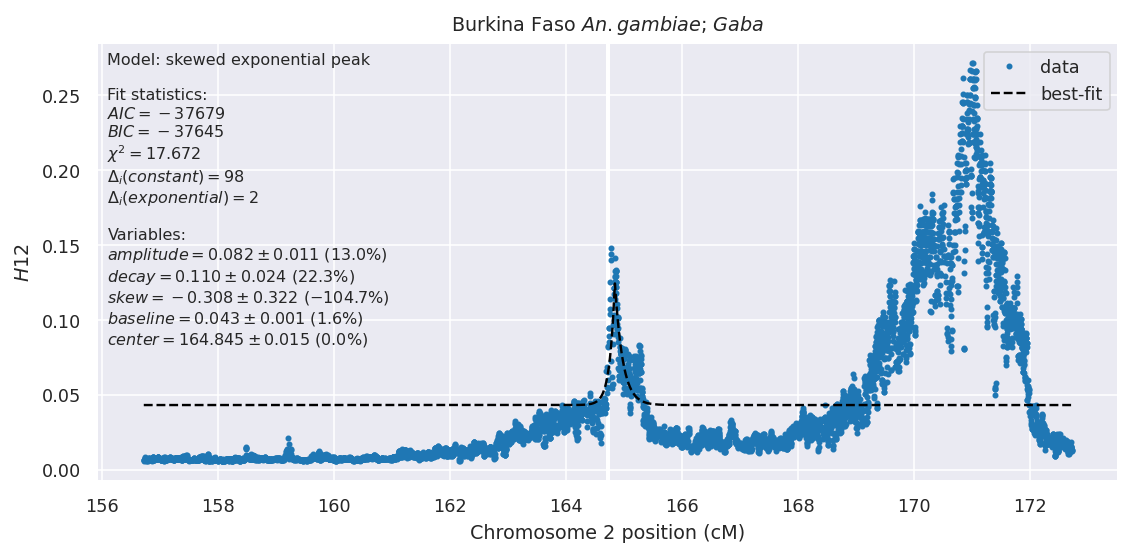

In [84]:
analyse_skewed_exponential_peak_fit('bf_gam', gaba, 8)

In [85]:
def analyse_twin_peak_fit(
    pop, chromosome, pcenter, gflank, 
    ax=None,
    median_filter_kws=None,
    hampel_filter_kws=None,
    recursive_hampel_filter_kws=None,
    ):

    # load gwss data
    pwindows, gwindows, _, signal, _, _ = load_h12_gwss(pop, chromosome)
    ppos = pwindows.mean(axis=1)
    gpos = gwindows.mean(axis=1)

    # locate center and region to fit
    gcenter = bp2cm(chromosome, pcenter)
    loc_region = slice(bisect_left(gpos, gcenter - gflank), 
                       bisect_right(gpos, gcenter + gflank))

    # filters
    if median_filter_kws:
        signal = scipy.ndimage.median_filter(signal, **median_filter_kws)
    if hampel_filter_kws:
        signal = hampel_filter(signal, **hampel_filter_kws)
    if recursive_hampel_filter_kws:
        signal = recursive_hampel_filter(signal, **recursive_hampel_filter_kws)

    # setup data to fit
    x = gpos[loc_region]
    y = signal[loc_region]

    # fit twin peak model
    left_peak_model = lmfit.Model(skewed_exponential_peak, prefix='left_')
    right_peak_model = lmfit.Model(skewed_exponential_peak, prefix='right_')
    twin_peak_model = left_peak_model + right_peak_model
    twin_peak_params = lmfit.Parameters()
    twin_peak_params['left_center'] = lmfit.Parameter('left_center', vary=True, value=gcenter-1, max=gcenter)
    twin_peak_params['left_amplitude'] = lmfit.Parameter('left_amplitude', vary=True, value=0.5, min=0.03, max=1)
    twin_peak_params['left_decay'] = lmfit.Parameter('left_decay', vary=True, value=0.5, min=0.1, max=3.0)
    twin_peak_params['left_skew'] = lmfit.Parameter('left_skew', vary=True, value=0, min=-1, max=1)
    twin_peak_params['left_baseline'] = lmfit.Parameter('left_baseline', vary=True, value=0.02, min=0, max=1)
    twin_peak_params['left_ceiling'] = lmfit.Parameter('left_ceiling', vary=False, value=1)
    twin_peak_params['left_floor'] = lmfit.Parameter('left_floor', vary=False, value=0)
    twin_peak_params['right_center'] = lmfit.Parameter('right_center', vary=True, value=gcenter+1, min=gcenter)
    twin_peak_params['right_amplitude'] = lmfit.Parameter('right_amplitude', vary=True, value=0.5, min=0.03, max=1)
    twin_peak_params['right_decay'] = lmfit.Parameter('right_decay', vary=True, value=0.5, min=0.1, max=3.0)
    twin_peak_params['right_skew'] = lmfit.Parameter('right_skew', vary=True, value=0, min=-1, max=1)
    twin_peak_params['right_baseline'] = lmfit.Parameter('right_baseline', expr='left_baseline')
#     twin_peak_params['right_baseline'] = lmfit.Parameter('right_baseline', vary=True, value=0.03, min=0, max=1)
    twin_peak_params['right_ceiling'] = lmfit.Parameter('right_ceiling', vary=False, value=1)
    twin_peak_params['right_floor'] = lmfit.Parameter('right_floor', vary=False, value=0)
    twin_peak_result = twin_peak_model.fit(y, x=x, params=twin_peak_params)
    print(twin_peak_result.fit_report())

    # fit skewed peak model
    skewed_peak_model = lmfit.Model(skewed_exponential_peak)
    skewed_peak_params = lmfit.Parameters()
    skewed_peak_params['center'] = lmfit.Parameter('center', vary=True, value=gcenter)
    skewed_peak_params['amplitude'] = lmfit.Parameter('amplitude', vary=True, value=0.5, min=0.03, max=1)
    skewed_peak_params['decay'] = lmfit.Parameter('decay', vary=True, value=0.5, min=0.1, max=3.0)
    skewed_peak_params['skew'] = lmfit.Parameter('skew', vary=True, value=0, min=-1, max=1)
    skewed_peak_params['baseline'] = lmfit.Parameter('baseline', vary=True, value=0.03, min=0, max=1)
    skewed_peak_params['ceiling'] = lmfit.Parameter('ceiling', vary=False, value=1)
    skewed_peak_params['floor'] = lmfit.Parameter('floor', vary=False, value=0)
    skewed_peak_result = skewed_peak_model.fit(y, x=x, params=skewed_peak_params)

    # fit null model
    null_model = lmfit.models.ConstantModel()
    null_params = lmfit.Parameters()
    null_params['c'] = lmfit.Parameter('c', vary=True, value=0.03, min=0, max=1)
    null_result = null_model.fit(y, x=x, params=null_params)

    # plot
    tidy_fig = False
    # if ax is None:
    tidy_fig = True
    fig, ax = plt.subplots(facecolor='w', figsize=(8, 4))
    twin_peak_result.plot_fit(
        ax=ax, 
        xlabel=f'Chromosome {chromosome} position (cM)', 
        ylabel='$H12$',
        data_kws=dict(markersize=2), 
        fit_kws=dict(color='k', linestyle='--')
    )
    ax.axvline(gcenter, color='w', lw=2, zorder=0)
    ax.annotate(
        f'Model: twin peak\n' +
        f'\nFit statistics:\n' + 
        f'$AIC={twin_peak_result.aic:.0f}$\n' +
        f'$BIC={twin_peak_result.bic:.0f}$\n' +
        f'$\\chi^{2}={twin_peak_result.chisqr:.3f}$\n' +
        f'$\\Delta_{{i}}(constant)={null_result.aic - twin_peak_result.aic:.0f}$\n' +
        f'$\\Delta_{{i}}(one peak)={skewed_peak_result.aic - twin_peak_result.aic:.0f}$\n',
        xy=(0, 1), xycoords='axes fraction',
        xytext=(5, -5), textcoords='offset points',
        va='top', ha='left', fontsize=8,
    )
    ax.set_title(f"{tex_math_species(pop_defs[pop]['label'])}")
    if tidy_fig:
        fig.tight_layout()

[[Model]]
    (Model(skewed_exponential_peak, prefix='left_') + Model(skewed_exponential_peak, prefix='right_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 471
    # data points      = 6603
    # variables        = 9
    chi-square         = 1.20024716
    reduced chi-square = 1.8202e-04
    Akaike info crit   = -56852.0006
    Bayesian info crit = -56790.8431
[[Variables]]
    left_center:      164.880371 +/- 0.01003371 (0.01%) (init = 167.7231)
    left_amplitude:   0.07996812 +/- 0.00127512 (1.59%) (init = 0.5)
    left_decay:       0.64885919 +/- 0.01650137 (2.54%) (init = 0.5)
    left_skew:        0.35446184 +/- 0.03210203 (9.06%) (init = 0)
    left_baseline:    0.00350969 +/- 1.5219e-04 (4.34%) (init = 0.02)
    left_ceiling:     1 (fixed)
    left_floor:       0 (fixed)
    right_center:     171.040609 +/- 0.00340531 (0.00%) (init = 169.7231)
    right_amplitude:  0.22887913 +/- 9.1975e-04 (0.40%) (init = 0.5)
    right_decay:      0.89435340 

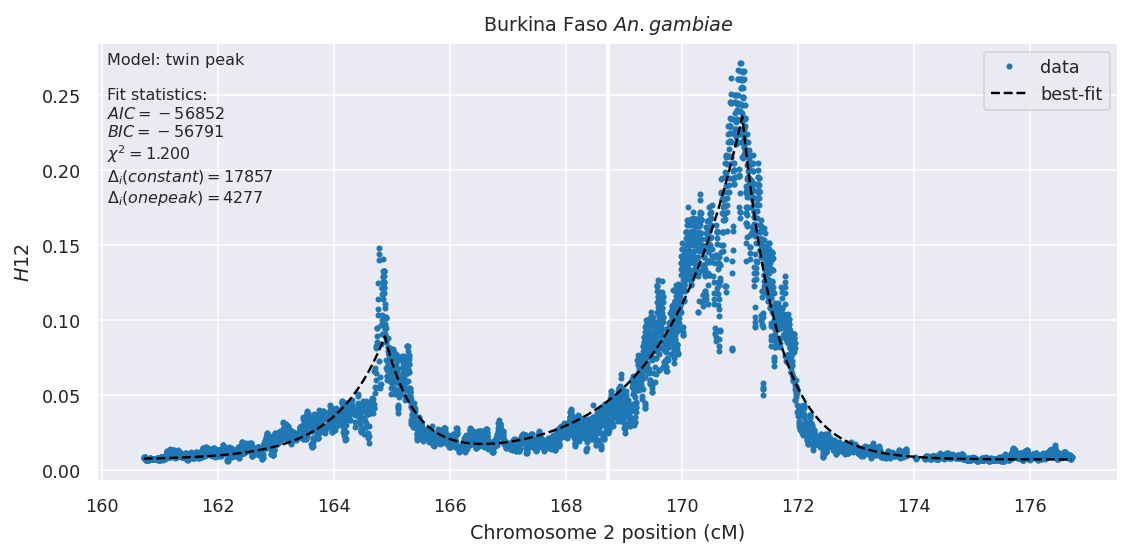

In [86]:
analyse_twin_peak_fit(
    pop='bf_gam',
    chromosome=gaba.chromosome,
    pcenter=gaba.chromosome_center + 2e6,
    gflank=8
)

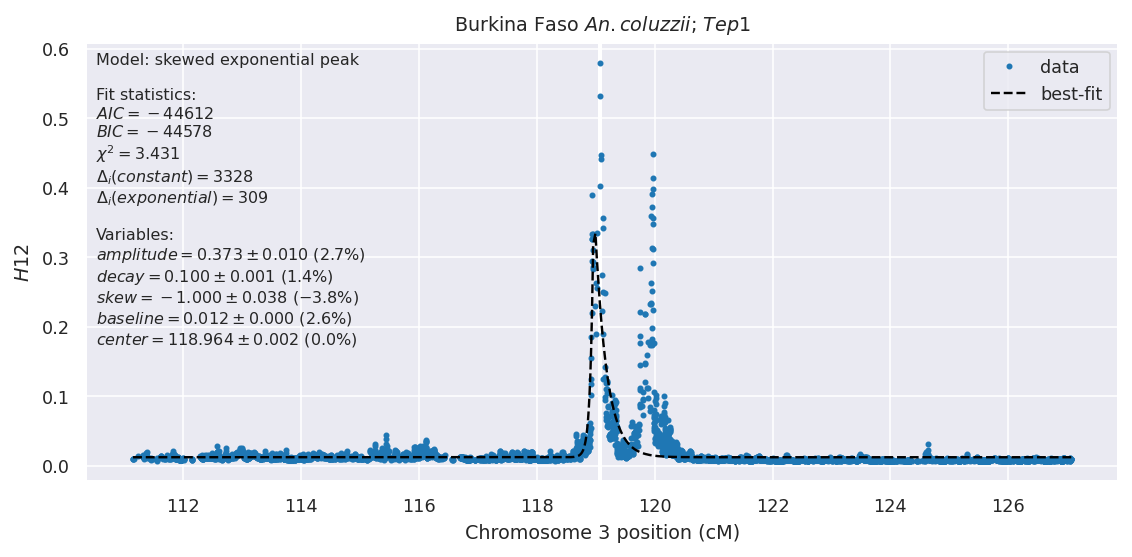

In [87]:
analyse_skewed_exponential_peak_fit(
    pop='bf_col',
    gene=tep1,
    gflank=8
)

[[Model]]
    (Model(skewed_exponential_peak, prefix='left_') + Model(skewed_exponential_peak, prefix='right_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 454
    # data points      = 5979
    # variables        = 9
    chi-square         = 1.55523781
    reduced chi-square = 2.6051e-04
    Akaike info crit   = -49334.9389
    Bayesian info crit = -49274.6748
[[Variables]]
    left_center:      118.978196 +/- 0.00175137 (0.00%) (init = 118.0716)
    left_amplitude:   0.40301076 +/- 0.00711585 (1.77%) (init = 0.5)
    left_decay:       0.10000002 +/- 0.00197519 (1.98%) (init = 0.5)
    left_skew:       -0.70625482 +/- 0.02809356 (3.98%) (init = 0)
    left_baseline:    0.00496086 +/- 1.0891e-04 (2.20%) (init = 0.02)
    left_ceiling:     1 (fixed)
    left_floor:       0 (fixed)
    right_center:     119.960107 +/- 0.00141189 (0.00%) (init = 120.0716)
    right_amplitude:  0.23868528 +/- 0.00374230 (1.57%) (init = 0.5)
    right_decay:      0.10000000 

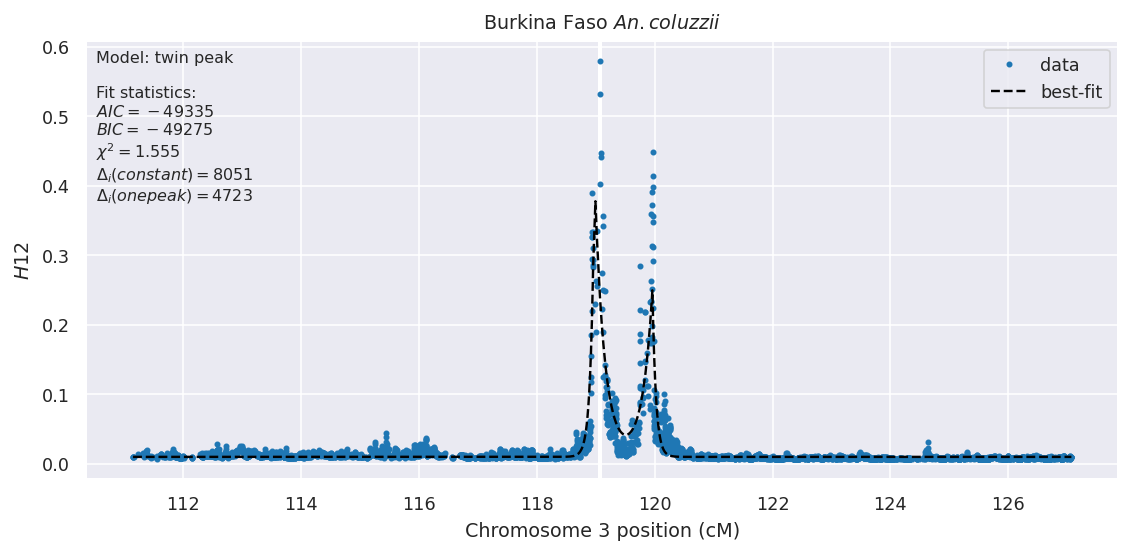

In [88]:
analyse_twin_peak_fit(
    pop='bf_col',
    chromosome=tep1.chromosome,
    pcenter=tep1.chromosome_center,
    gflank=8
)

In [5]:
def compare_peak_models(pop, gene, gflank):
    
    chromosome = gene.chromosome
    pcenter = gene.chromosome_center
    locus = gene.Name
    
    # load gwss data
    pwindows, gwindows, _, h12, _, _ = load_h12_gwss(pop, chromosome)
    ppos = pwindows.mean(axis=1)
    gpos = gwindows.mean(axis=1)

    # locate center and region to fit
    gcenter = bp2cm(chromosome, pcenter)
    loc_region = slice(bisect_left(gpos, gcenter - gflank), 
                       bisect_right(gpos, gcenter + gflank))
    
    # setup data to fit
    x = gpos[loc_region]
    y = h12[loc_region]

    # filtered signals
    signals = dict(
        no_filter=y,
#         median_filter=scipy.ndimage.median_filter(y, size=20),
        hampel_filter_t1=hampel_filter(y, size=20, t=1),
#         hampel_filter_t2=hampel_filter(y, size=20, t=2),
    )

    # setup symmetric exponential peak model
    exp_peak_model = lmfit.Model(exponential_peak)
    exp_peak_params = lmfit.Parameters()
    exp_peak_params['center'] = lmfit.Parameter('center', vary=True, value=gcenter)
    exp_peak_params['amplitude'] = lmfit.Parameter('amplitude', vary=True, value=0.5, min=0, max=1)
    exp_peak_params['decay'] = lmfit.Parameter('decay', vary=True, value=0.5, min=0.15, max=3.0)
    exp_peak_params['baseline'] = lmfit.Parameter('baseline', vary=True, value=0.03, min=0, max=1)
    exp_peak_params['ceiling'] = lmfit.Parameter('ceiling', vary=False, value=1)
    exp_peak_params['floor'] = lmfit.Parameter('floor', vary=False, value=0)
    exp_peak = exp_peak_model, exp_peak_params

    # setup skewed exponential peak model
    skewed_exp_peak_model = lmfit.Model(skewed_exponential_peak)
    skewed_exp_peak_params = lmfit.Parameters()
    skewed_exp_peak_params['center'] = lmfit.Parameter('center', vary=True, value=gcenter)
    skewed_exp_peak_params['amplitude'] = lmfit.Parameter('amplitude', vary=True, value=0.5, min=0, max=1)
    skewed_exp_peak_params['decay'] = lmfit.Parameter('decay', vary=True, value=0.5, min=0.15, max=3.0)
    skewed_exp_peak_params['skew'] = lmfit.Parameter('skew', vary=True, value=0, min=-1, max=1)
    skewed_exp_peak_params['baseline'] = lmfit.Parameter('baseline', vary=True, value=0.03, min=0, max=1)
    skewed_exp_peak_params['ceiling'] = lmfit.Parameter('ceiling', vary=False, value=1)
    skewed_exp_peak_params['floor'] = lmfit.Parameter('floor', vary=False, value=0)
    skewed_exp_peak = skewed_exp_peak_model, skewed_exp_peak_params

#     # setup skewed gaussian peak model
#     skewed_gauss_peak_model = lmfit.Model(skewed_gaussian_peak)
#     skewed_gauss_peak_params = lmfit.Parameters()
#     skewed_gauss_peak_params['center'] = lmfit.Parameter('center', vary=True, value=gcenter)
#     skewed_gauss_peak_params['amplitude'] = lmfit.Parameter('amplitude', vary=True, value=0.5, min=0, max=1)
#     skewed_gauss_peak_params['sigma'] = lmfit.Parameter('sigma', vary=True, value=0.5, min=0.15, max=3.0)
#     skewed_gauss_peak_params['skew'] = lmfit.Parameter('skew', vary=True, value=0, min=-1, max=1)
#     skewed_gauss_peak_params['baseline'] = lmfit.Parameter('baseline', vary=True, value=0.03, min=0, max=1)
#     skewed_gauss_peak_params['ceiling'] = lmfit.Parameter('ceiling', vary=False, value=1)
#     skewed_gauss_peak_params['floor'] = lmfit.Parameter('floor', vary=False, value=0)
#     skewed_gauss_peak = skewed_gauss_peak_model, skewed_gauss_peak_params
    
    # setup comparison matrix
#     peaks = exp_peak, skewed_exp_peak, skewed_gauss_peak
    peaks = exp_peak, skewed_exp_peak
    
    # setup output
    records = []
    
    # fit peak models
    best_result = None
    for (model, params), (filter_name, signal) in itertools.product(peaks, signals.items()):
        result = model.fit(signal, x=x, params=params.copy())
        model_name = model.name[6:-1]
        record = dict(
            locus=gene.Name,
            population=pop,
            model=model_name,
            filter=filter_name,
            aic=result.aic,
            center_stderr=result.params['center'].stderr,
            target_error=result.params['center'].value - gcenter,
            abs_target_error=np.abs(result.params['center'].value - gcenter)
        )
        record['model/filter'] = f'{model_name}/{filter_name}'
        records.append(record)
        if best_result is None:
            best_result = result
        elif result.aic < best_result.aic:
            best_result = result
    
    # add record for best fit
    record = dict(
        locus=gene.Name,
        population=pop,
        model='best_aic',
        filter='best_aic',
        aic=best_result.aic,
        center_stderr=best_result.params['center'].stderr,
        target_error=best_result.params['center'].value - gcenter,
        abs_target_error=np.abs(best_result.params['center'].value - gcenter)
    )
    record['model/filter'] = 'best_aic'
    records.append(record)
    
    # add record for peak value, look within 1 cM
    loc_prox = slice(bisect_left(gpos, gcenter - 1), 
                     bisect_right(gpos, gcenter + 1))
    x_prox = gpos[loc_prox]
    y_prox = h12[loc_prox]
    peak_idx = np.argmax(y_prox)
    peak_x = x_prox[peak_idx]
    record = dict(
        locus=gene.Name,
        population=pop,
        model='peak_value',
        filter='no_filter',
        aic=0,
        center_stderr=0,
        target_error=peak_x - gcenter,
        abs_target_error=np.abs(peak_x - gcenter)
    )
    record['model/filter'] = 'peak_value'
    records.append(record)

#     # fit constant model
#     null_model = lmfit.models.ConstantModel()
#     null_params = lmfit.Parameters()
#     null_params['c'] = lmfit.Parameter('c', vary=True, value=0.03, min=0, max=1)
#     null_results = {
#         f: null_model.fit(y)
#     }
    
    return pd.DataFrame.from_records(records)

    

In [6]:
def locus_comparison(gene, tp_pops, gflank):

    df = pd.concat([
        compare_peak_models(pop, gene, gflank)
        for pop in tp_pops
    ])

    fig, ax = plt.subplots(facecolor='w', figsize=(4, 4))
    sns.swarmplot(x='abs_target_error', y='model/filter', data=df, orient='h', ax=ax)
    ax.set_xlabel('Target error (cM)')
    ax.set_ylabel('Model / Filter')
    ax.set_title(f'${gene.Name}$')
    
    return df

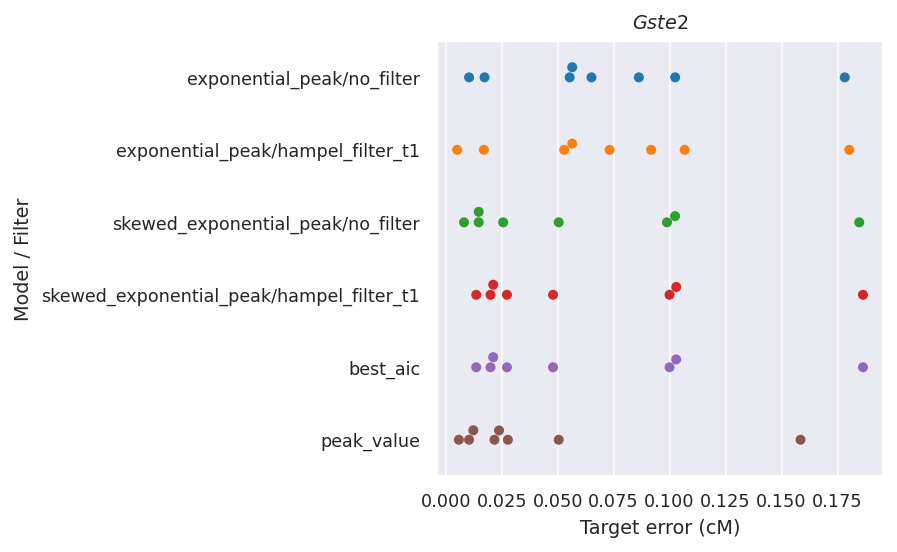

In [7]:
gste2_tp_pops = 'bf_gam', 'gn_gam', 'cm_sav_gam', 'ug_gam', 'ga_gam', 'bf_col', 'ci_col', 'gh_col'
df_gste2 = locus_comparison(gste2, gste2_tp_pops, 4)

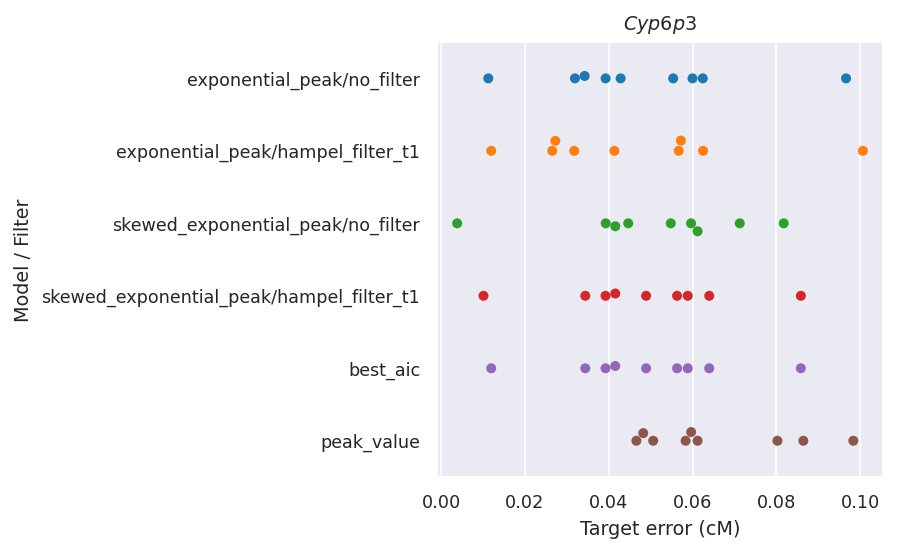

In [258]:
cyp6p3_tp_pops = 'bf_gam', 'gn_gam', 'gh_gam', 'cm_sav_gam', 'ug_gam', 'bf_col', 'ci_col', 'gh_col', 'gm'
df_cyp6p3 = locus_comparison(cyp6p3, cyp6p3_tp_pops, 4)

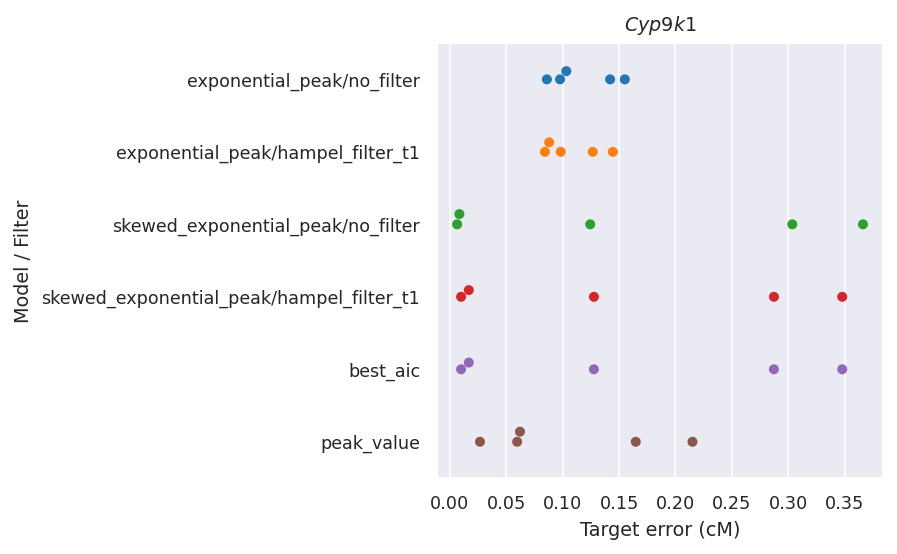

In [259]:
cyp9k1_tp_pops = 'bf_gam', 'gn_gam', 'bf_col', 'ci_col', 'gh_col'
df_cyp9k1 = locus_comparison(cyp9k1, cyp9k1_tp_pops, 8)

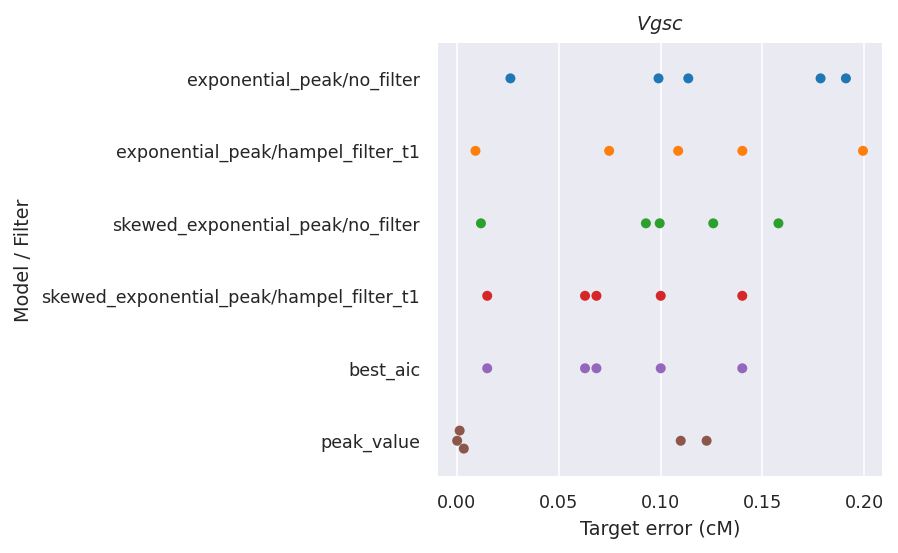

In [260]:
vgsc_tp_pops = 'bf_gam', 'gn_gam', 'bf_col', 'ci_col', 'gh_col'
df_vgsc = locus_comparison(vgsc, vgsc_tp_pops, 8)

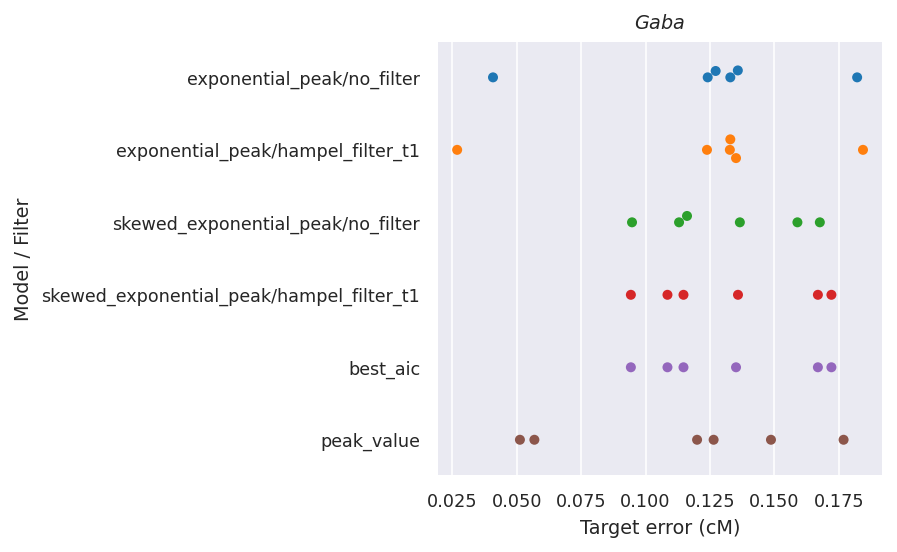

In [261]:
gaba_tp_pops = 'bf_gam', 'gh_gam', 'ga_gam', 'bf_col', 'ci_col', 'gh_col'
df_gaba = locus_comparison(gaba, gaba_tp_pops, 4)

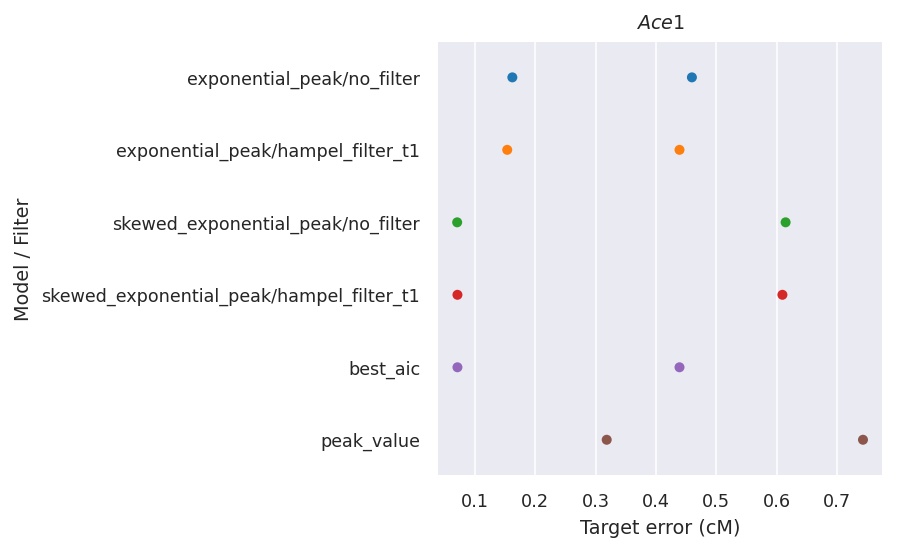

In [262]:
ace1_tp_pops = 'gh_gam', 'ci_col'
df_ace1 = locus_comparison(ace1, ace1_tp_pops, 4)

Text(0.5, 1.0, 'All IR genes')

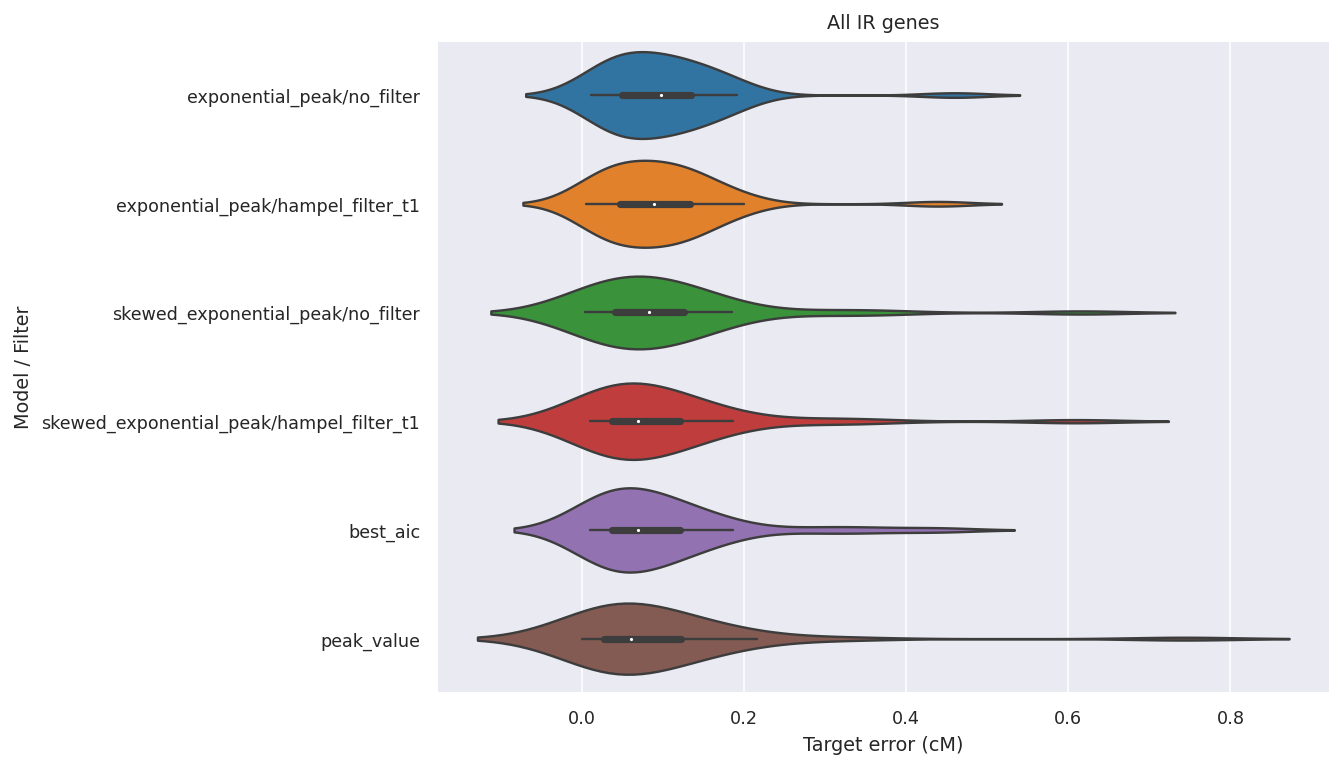

In [281]:
df_all = pd.concat([df_gste2, df_cyp6p3, df_cyp9k1, df_vgsc, df_gaba, df_ace1])
fig, ax = plt.subplots(facecolor='w', figsize=(8, 6))
sns.violinplot(x='abs_target_error', y='model/filter', data=df_all, orient='h', ax=ax)
ax.set_xlabel('Target error (cM)')
ax.set_ylabel('Model / Filter')
ax.set_title(f'All IR genes')


(0.18824747400717237, 0.025923399987904907)

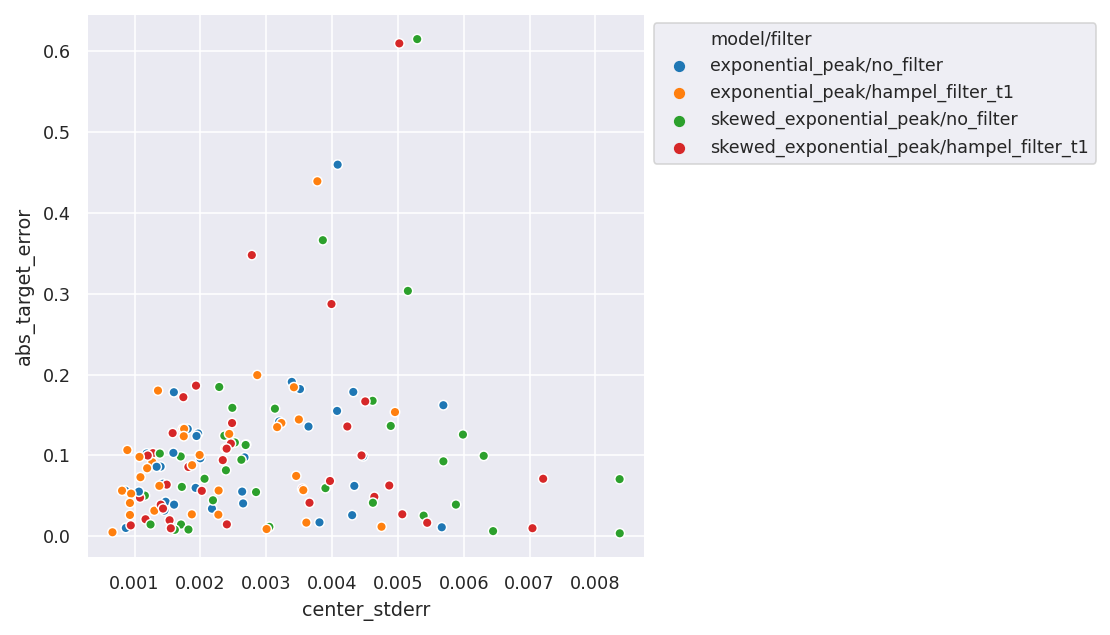

In [292]:
fig, ax = plt.subplots(figsize=(5, 5), facecolor='w')
loc = (df_all.model != 'peak_value') & (df_all.model != 'best_aic')
df = df_all.loc[loc]
# x = df_all.center_stderr[loc]
# y = df_all.abs_target_error[loc]
# ax.plot(x, y, marker='o', linestyle=' ')
g = sns.scatterplot(x='center_stderr', y='abs_target_error', hue='model/filter', data=df, ax=ax)
g.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.set_xlabel('Center stderr')
# ax.set_ylabel('Target error')
r, p = scipy.stats.pearsonr(x, y)
r, p

In [265]:
df_all.head()

locus population                    model            filter           aic  \
0  Gste2     bf_gam         exponential_peak         no_filter -35803.532039   
1  Gste2     bf_gam         exponential_peak  hampel_filter_t1 -37963.191691   
2  Gste2     bf_gam  skewed_exponential_peak         no_filter -35803.527738   
3  Gste2     bf_gam  skewed_exponential_peak  hampel_filter_t1 -37976.601110   
4  Gste2     bf_gam                 best_aic          best_aic -37976.601110   

   center_stderr  target_error  abs_target_error  \
0       0.001180     -0.102469          0.102469   
1       0.000888     -0.106712          0.106712   
2       0.001700     -0.098815          0.098815   
3       0.001277     -0.102942          0.102942   
4       0.001277     -0.102942          0.102942   

                               model/filter  
0                exponential_peak/no_filter  
1         exponential_peak/hampel_filter_t1  
2         skewed_exponential_peak/no_filter  
3  skewed_exponential_peak/hampel_filter_t1  
4                                  best_aic

In [267]:
df_piv = df_all.pivot(index=['locus', 'population'], columns='model/filter', values='abs_target_error')
df_piv.head()

model/filter       best_aic  exponential_peak/hampel_filter_t1  \
locus  population                                                
Ace1   ci_col      0.438996                           0.438996   
       gh_gam      0.071248                           0.153692   
Cyp6p3 bf_col      0.056296                           0.062493   
       bf_gam      0.063969                           0.031763   
       ci_col      0.034401                           0.026512   

model/filter       exponential_peak/no_filter  peak_value  \
locus  population                                           
Ace1   ci_col                        0.459530    0.318426   
       gh_gam                        0.162169    0.742859   
Cyp6p3 bf_col                        0.059973    0.050600   
       bf_gam                        0.031926    0.058327   
       ci_col                        0.039240    0.080241   

model/filter       skewed_exponential_peak/hampel_filter_t1  \
locus  population                                             
Ace1   ci_col                                      0.609436   
       gh_gam                                      0.071248   
Cyp6p3 bf_col                                      0.056296   
       bf_gam                                      0.063969   
       ci_col                                      0.034401   

model/filter       skewed_exponential_peak/no_filter  
locus  population                                     
Ace1   ci_col                               0.614722  
       gh_gam                               0.070783  
Cyp6p3 bf_col                               0.054785  
       bf_gam                               0.061190  
       ci_col                               0.071253

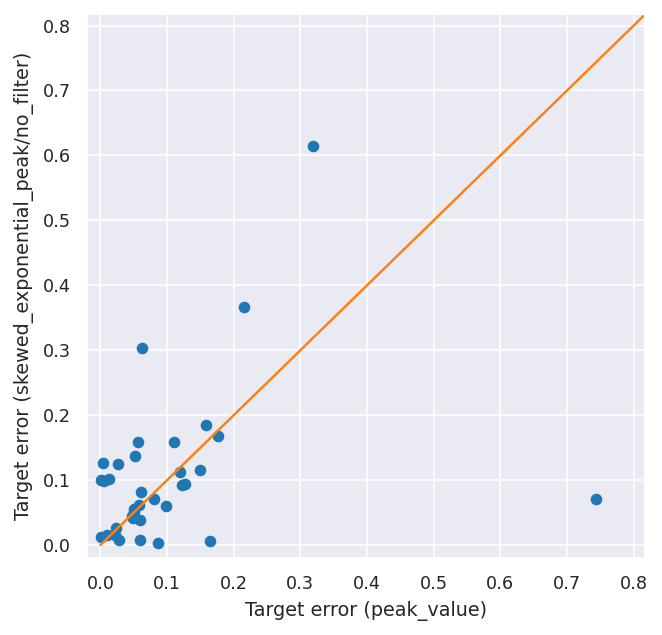

In [273]:
x = df_piv['peak_value']
y = df_piv['skewed_exponential_peak/no_filter']
fig, ax = plt.subplots(figsize=(5, 5), facecolor='w')
ax.plot(x, y, marker='o', linestyle=' ')
ax.set_xlabel('Target error (peak_value)')
ax.set_ylabel('Target error (skewed_exponential_peak/no_filter)')
lim = 1.1*max(x.max(), y.max())
ax.set_xlim(-0.02, lim)
ax.set_ylim(-0.02, lim)
ax.plot([0, lim], [0, lim]);

In [279]:
(df_piv['peak_value'] < df_piv['skewed_exponential_peak/no_filter']).value_counts()

True     19
False    16
dtype: int64

In [280]:
(df_piv['exponential_peak/no_filter'] < df_piv['skewed_exponential_peak/no_filter']).value_counts()

False    19
True     16
dtype: int64

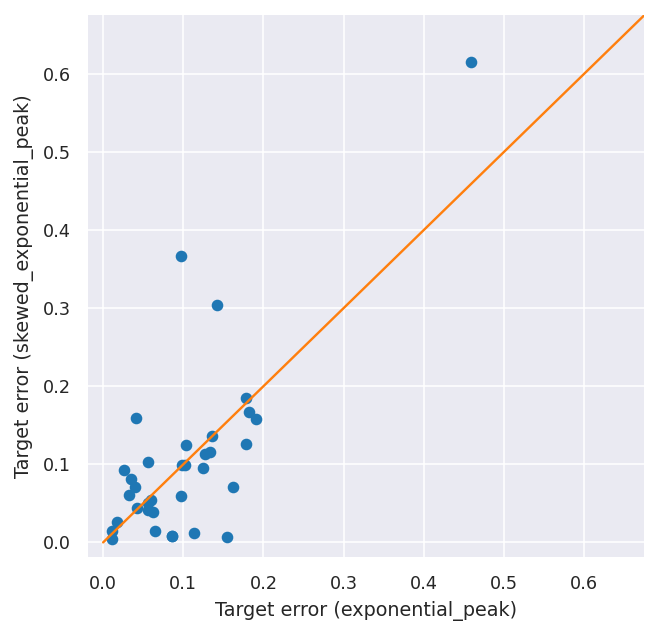

In [274]:
x = df_piv['exponential_peak/no_filter']
y = df_piv['skewed_exponential_peak/no_filter']
fig, ax = plt.subplots(figsize=(5, 5), facecolor='w')
ax.plot(x, y, marker='o', linestyle=' ')
ax.set_xlabel('Target error (exponential_peak)')
ax.set_ylabel('Target error (skewed_exponential_peak)')
lim = 1.1*max(x.max(), y.max())
ax.set_xlim(-0.02, lim)
ax.set_ylim(-0.02, lim)
ax.plot([0, lim], [0, lim]);

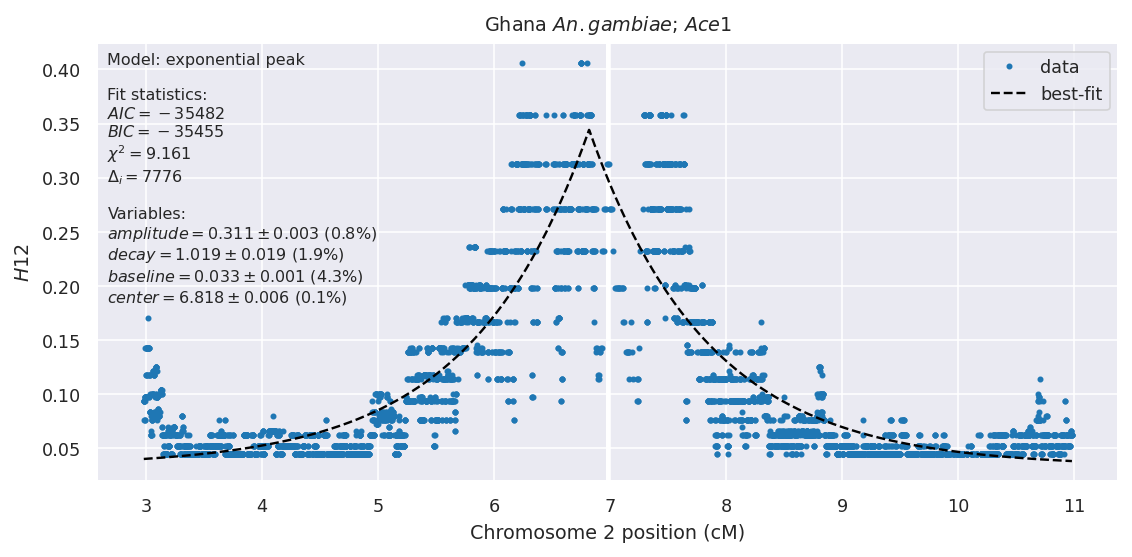

In [210]:
analyse_exponential_peak_fit('gh_gam', ace1, 4)

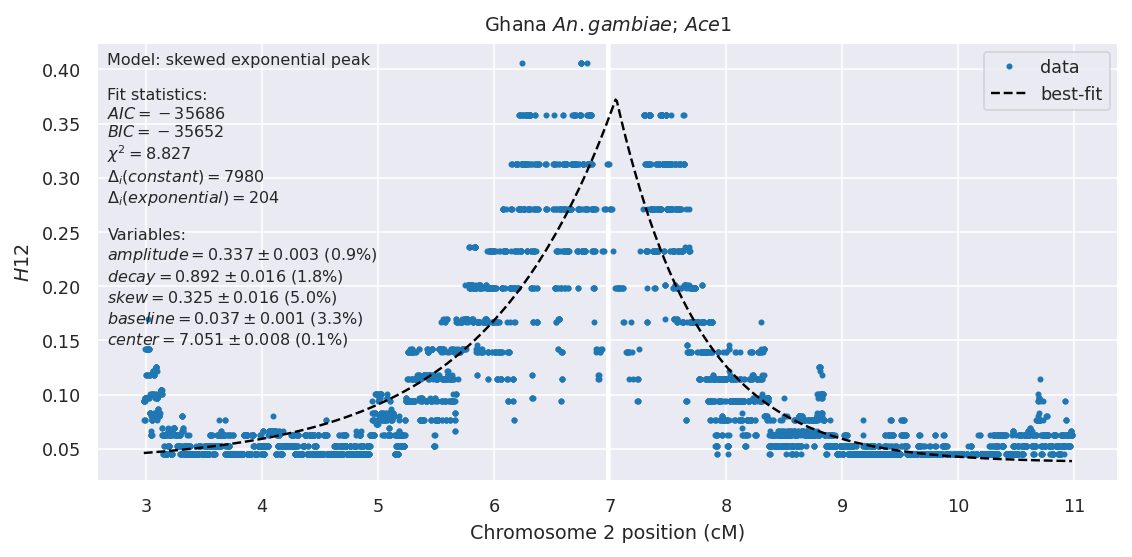

In [207]:
analyse_skewed_exponential_peak_fit('gh_gam', ace1, 4)

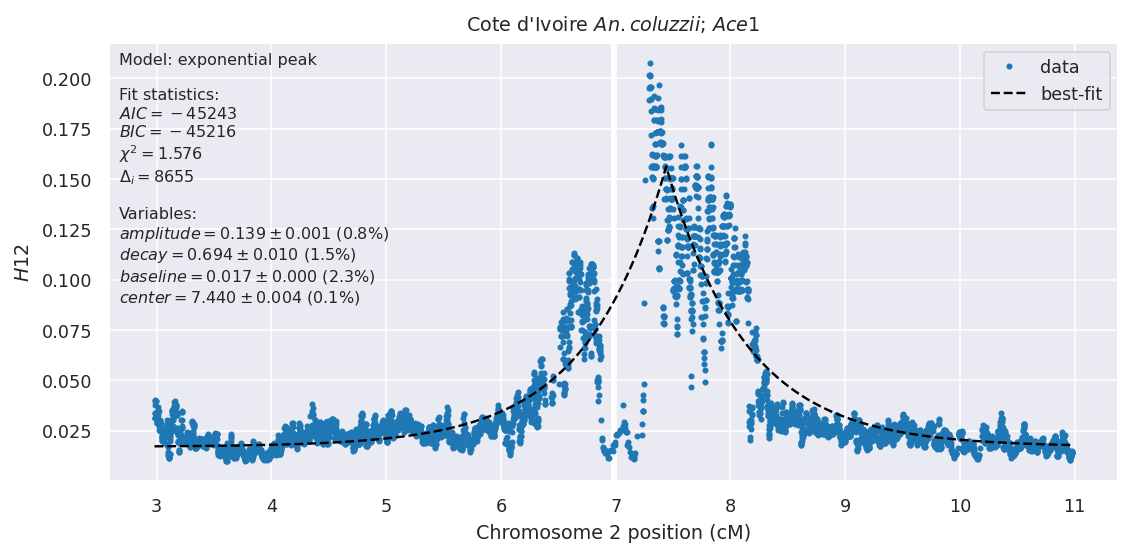

In [209]:
analyse_exponential_peak_fit('ci_col', ace1, 4)

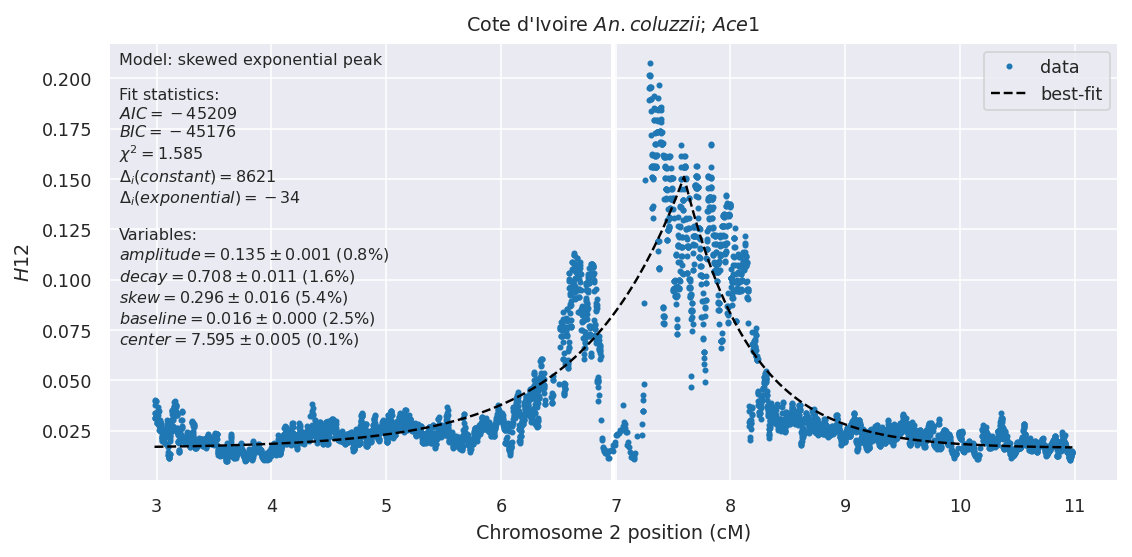

In [208]:
analyse_skewed_exponential_peak_fit('ci_col', ace1, 4)

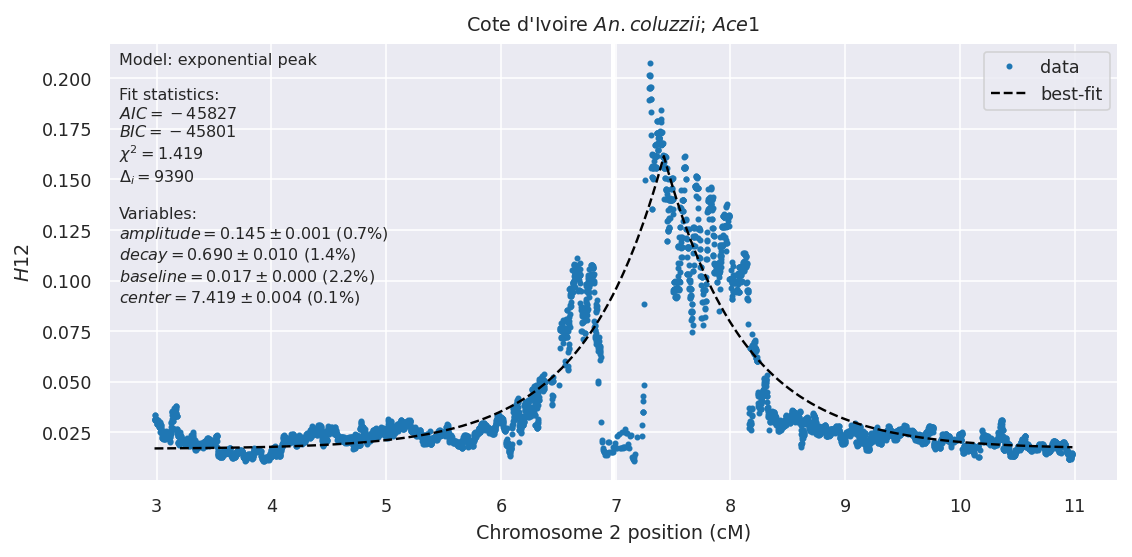

In [204]:
analyse_exponential_peak_fit('ci_col', ace1, 4, hampel_filter_kws=dict(size=20, t=1))

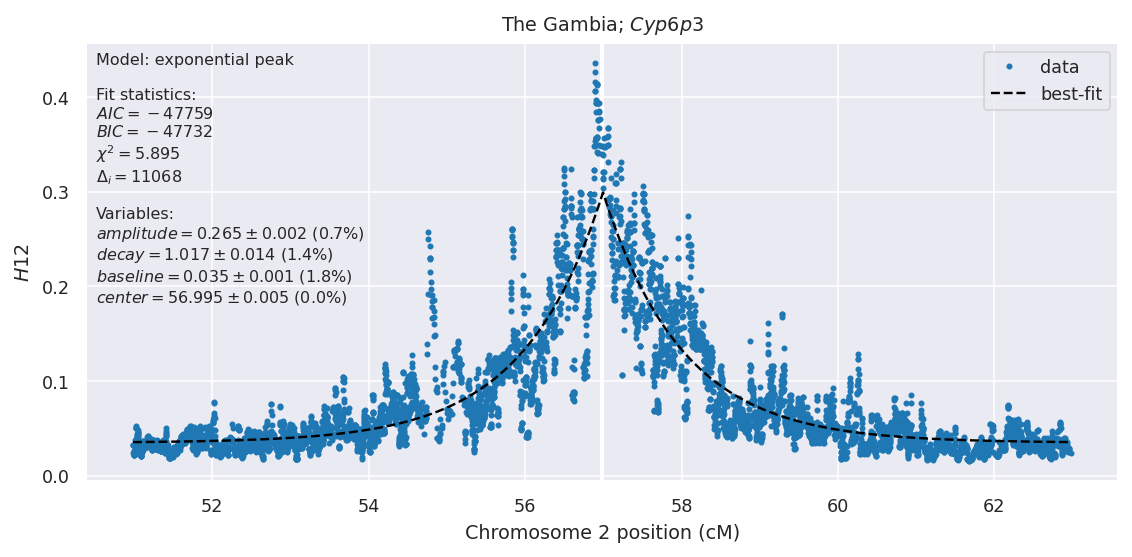

In [188]:
analyse_exponential_peak_fit('gm', cyp6p3, 6)

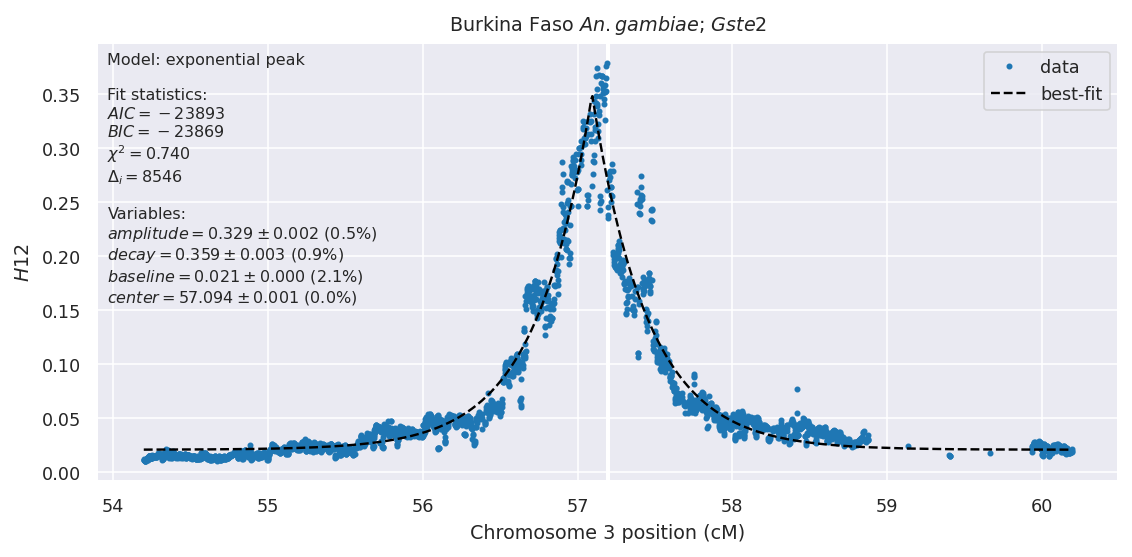

In [40]:
analyse_exponential_peak_fit('bf_gam', gste2, 3)

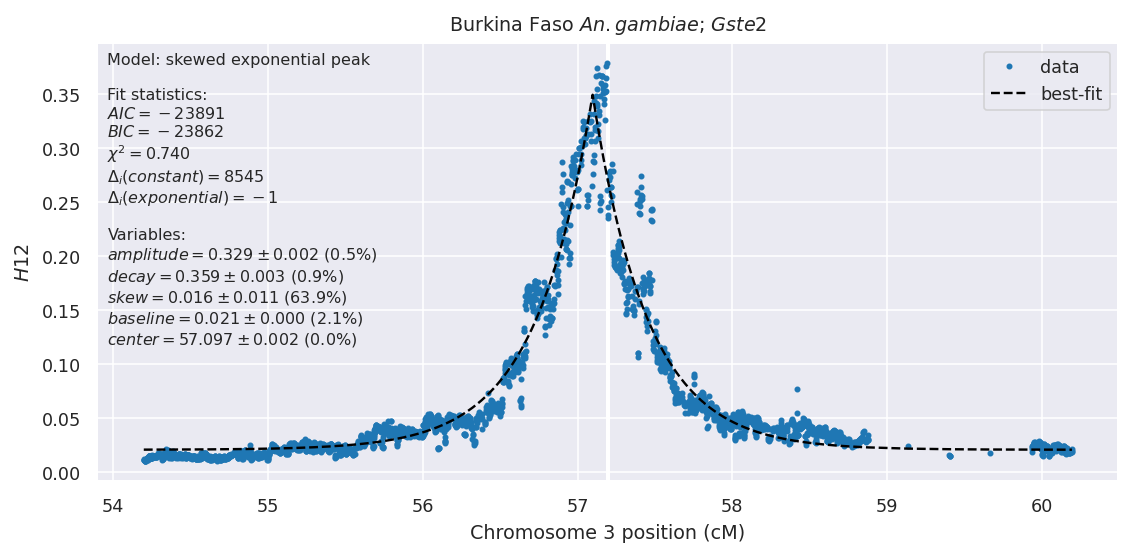

In [41]:
analyse_skewed_exponential_peak_fit('bf_gam', gste2, 3)

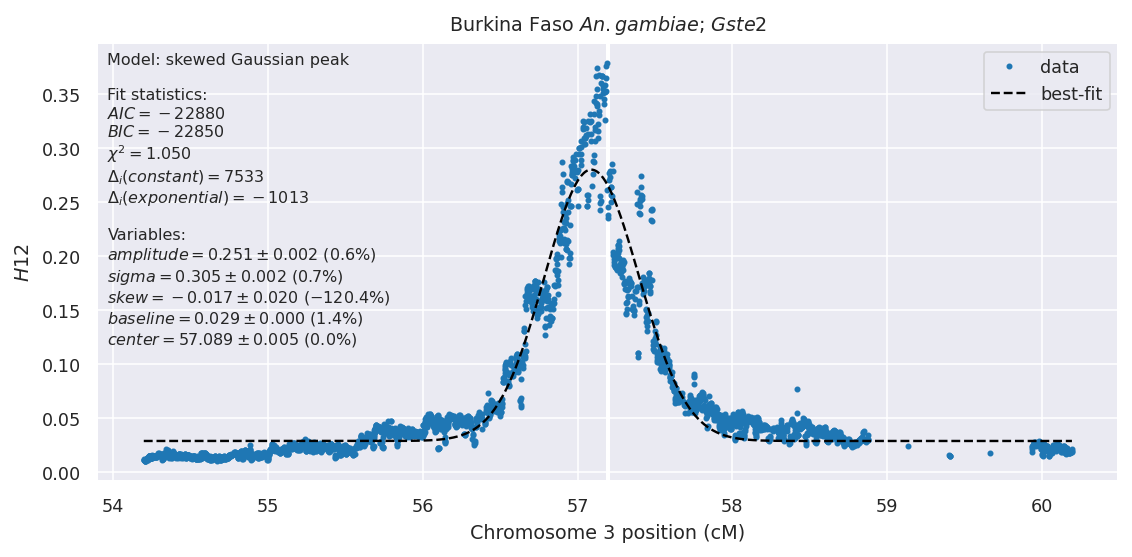

In [58]:
analyse_gaussian_peak_fit('bf_gam', gste2, 3)

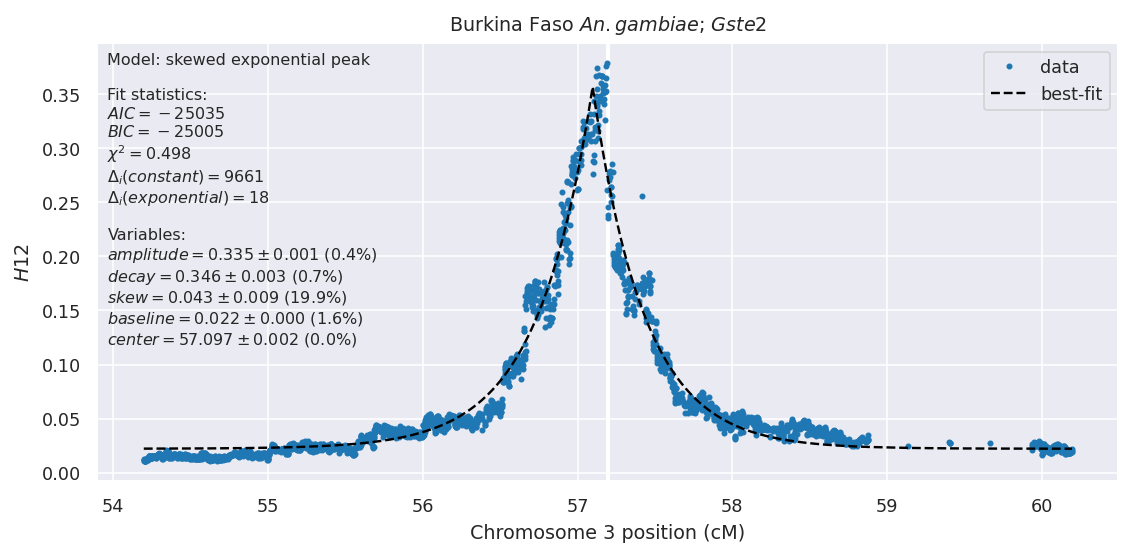

In [42]:
analyse_skewed_exponential_peak_fit('bf_gam', gste2, 3, hampel_filter_kws=dict(size=20, t=2))

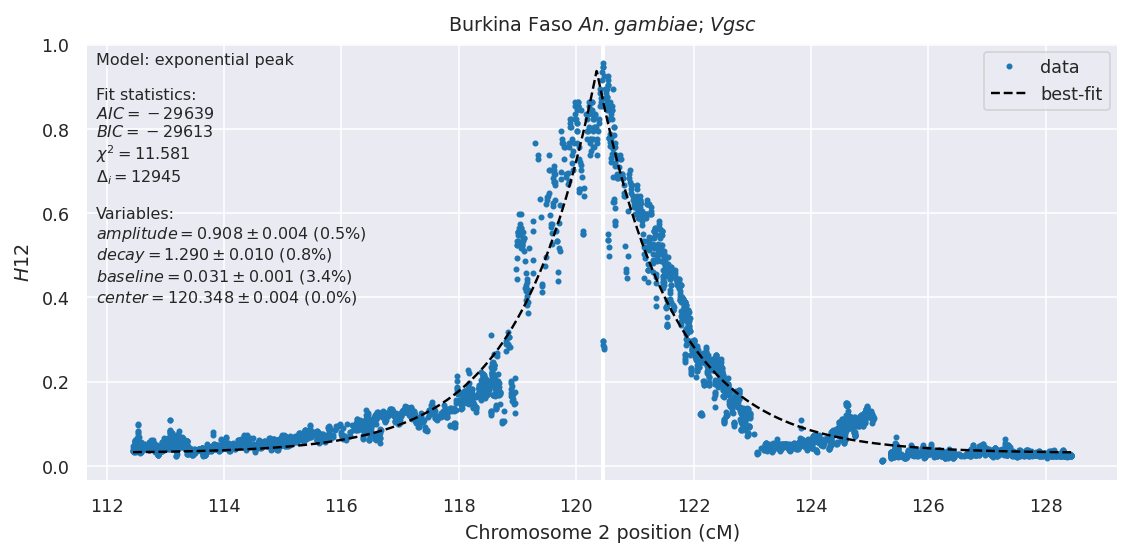

In [43]:
analyse_exponential_peak_fit('bf_gam', vgsc, 8)

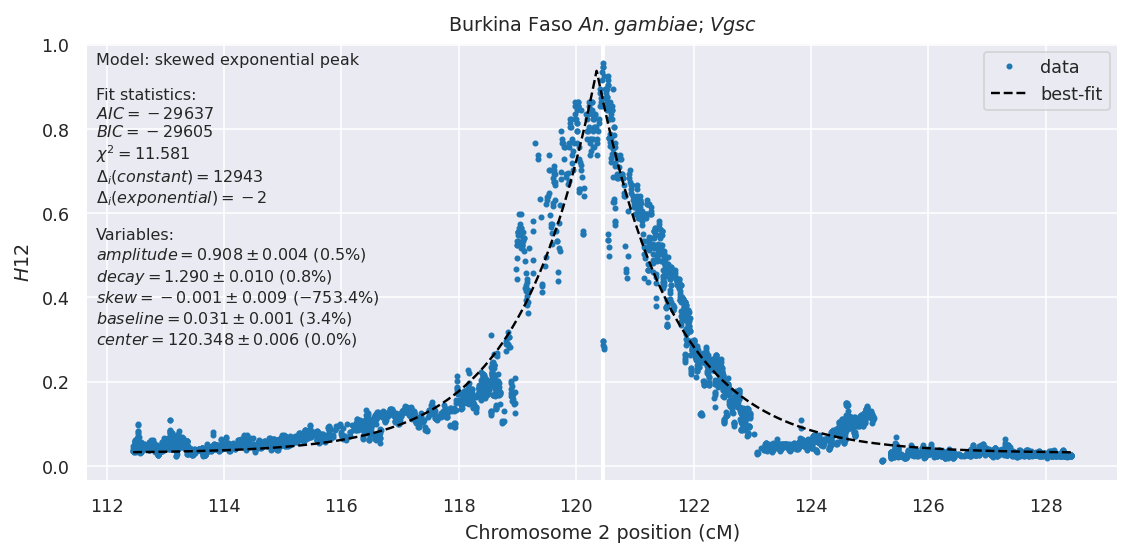

In [44]:
analyse_skewed_exponential_peak_fit('bf_gam', vgsc, 8)

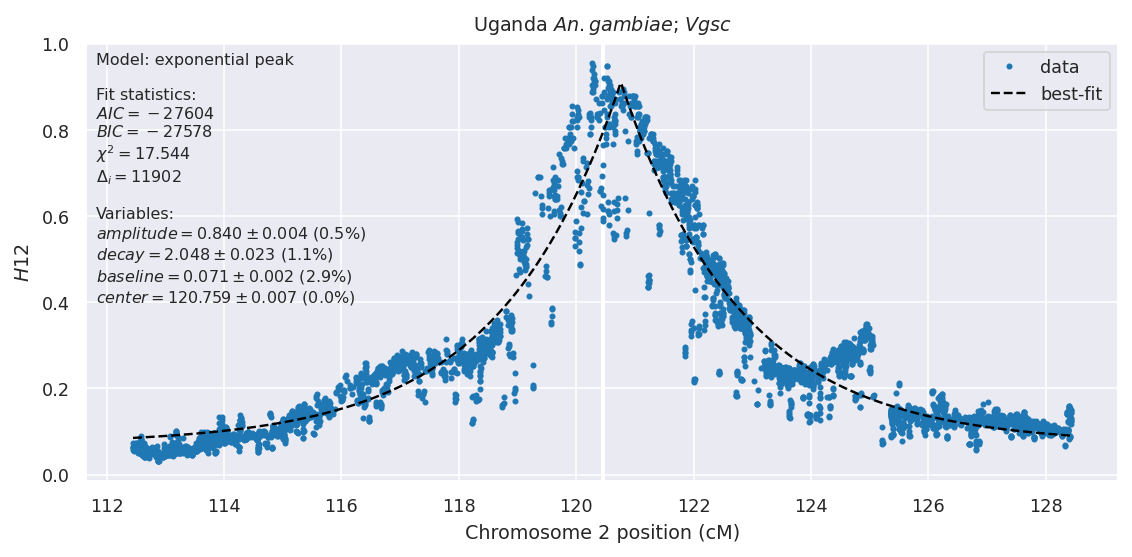

In [45]:
analyse_exponential_peak_fit('ug_gam', vgsc, 8)

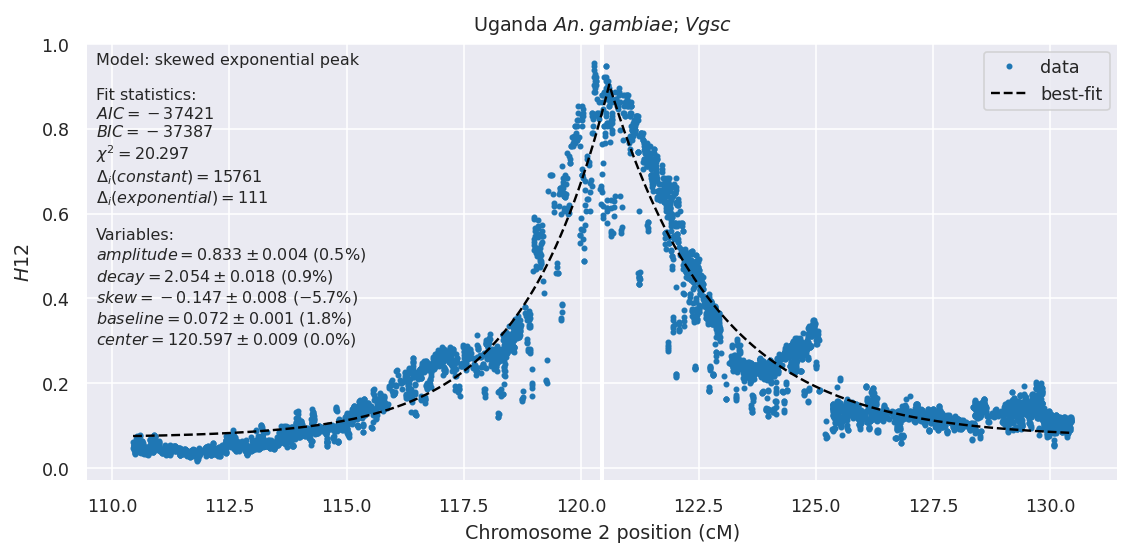

In [62]:
analyse_skewed_exponential_peak_fit('ug_gam', vgsc, 10)

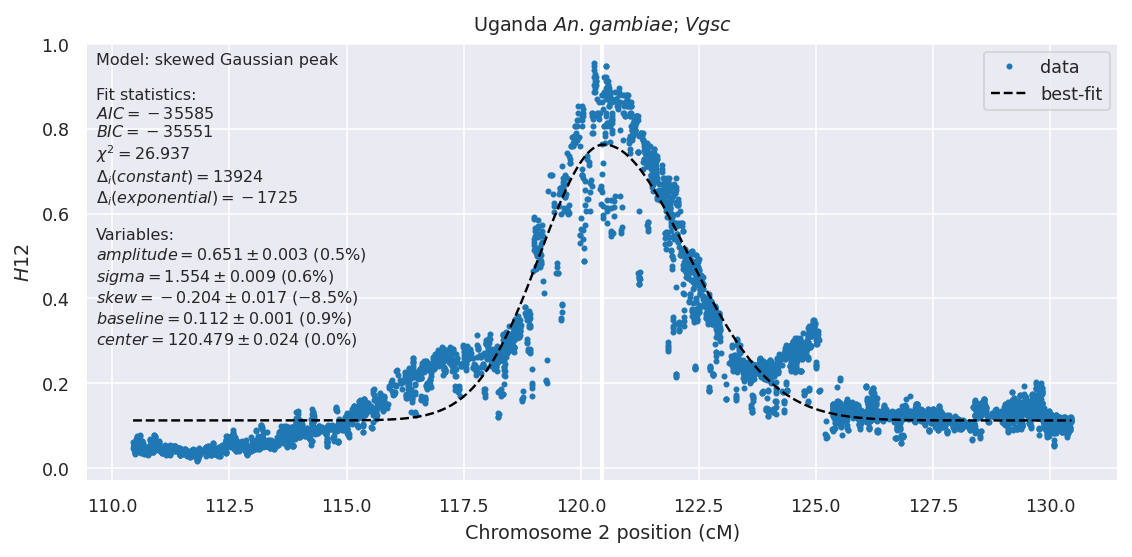

In [63]:
analyse_gaussian_peak_fit('ug_gam', vgsc, 10)

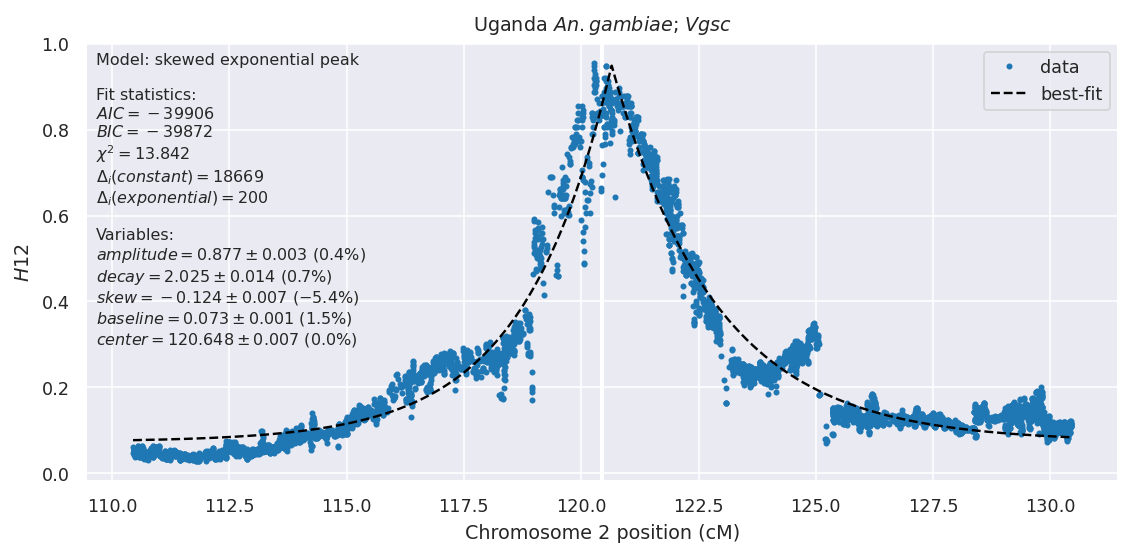

In [64]:
analyse_skewed_exponential_peak_fit('ug_gam', vgsc, 10, hampel_filter_kws=dict(size=20, t=2))

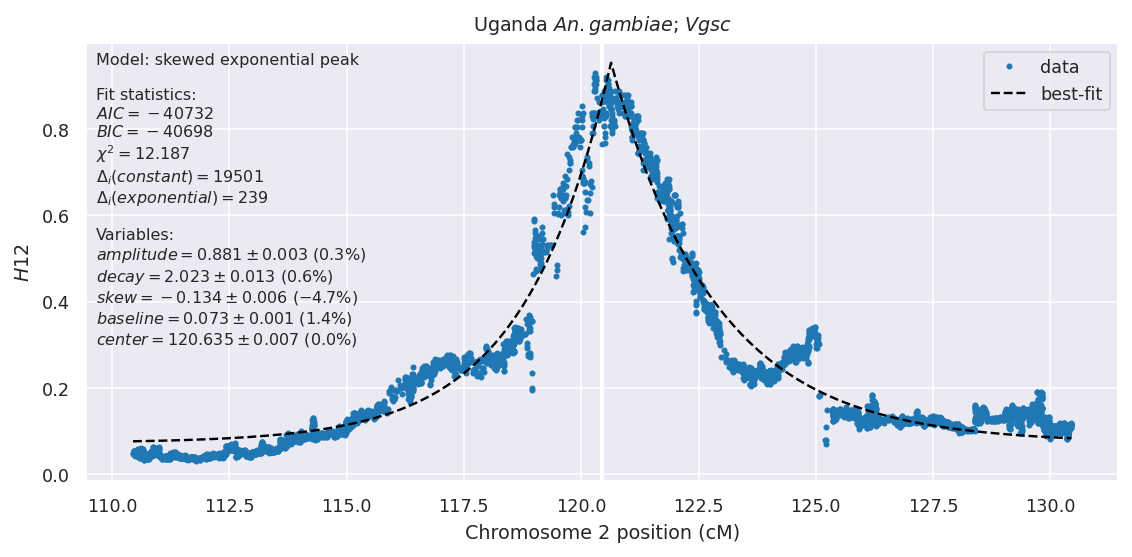

In [65]:
analyse_skewed_exponential_peak_fit('ug_gam', vgsc, 10, hampel_filter_kws=dict(size=20, t=1))

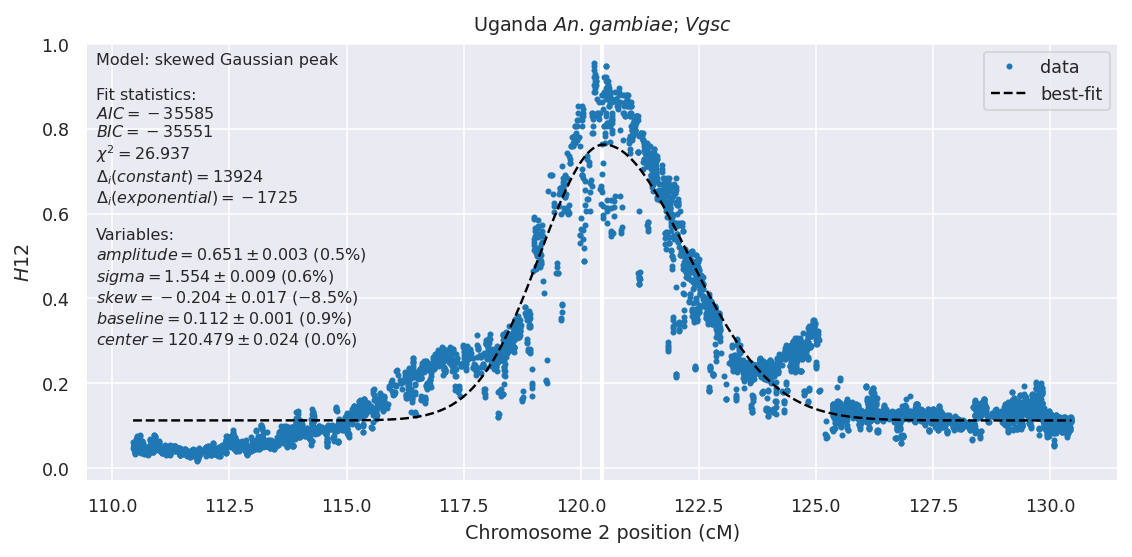

In [66]:
analyse_gaussian_peak_fit('ug_gam', vgsc, 10)

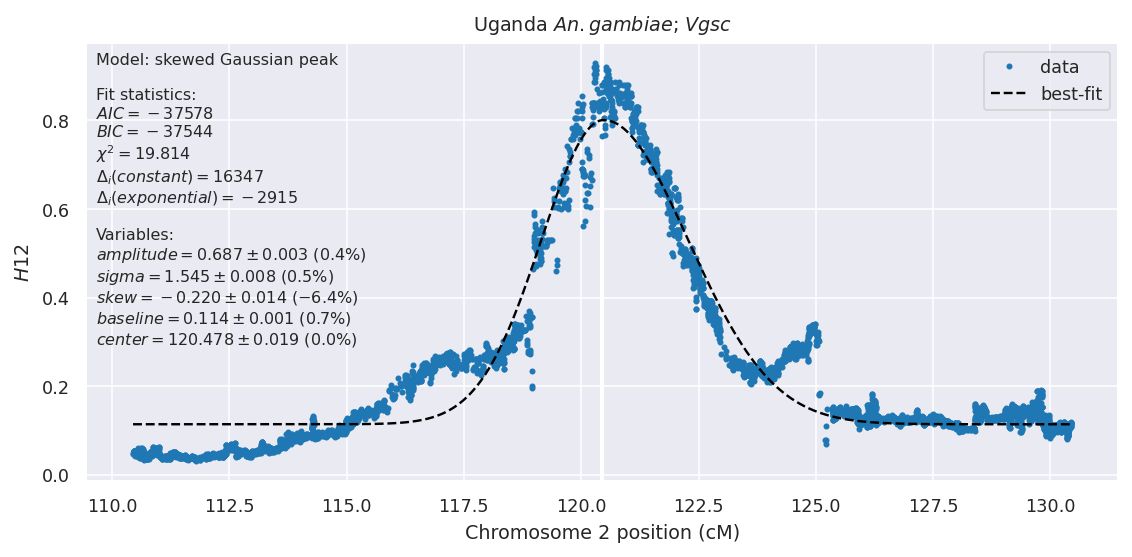

In [67]:
analyse_gaussian_peak_fit('ug_gam', vgsc, 10, hampel_filter_kws=dict(size=20, t=1))

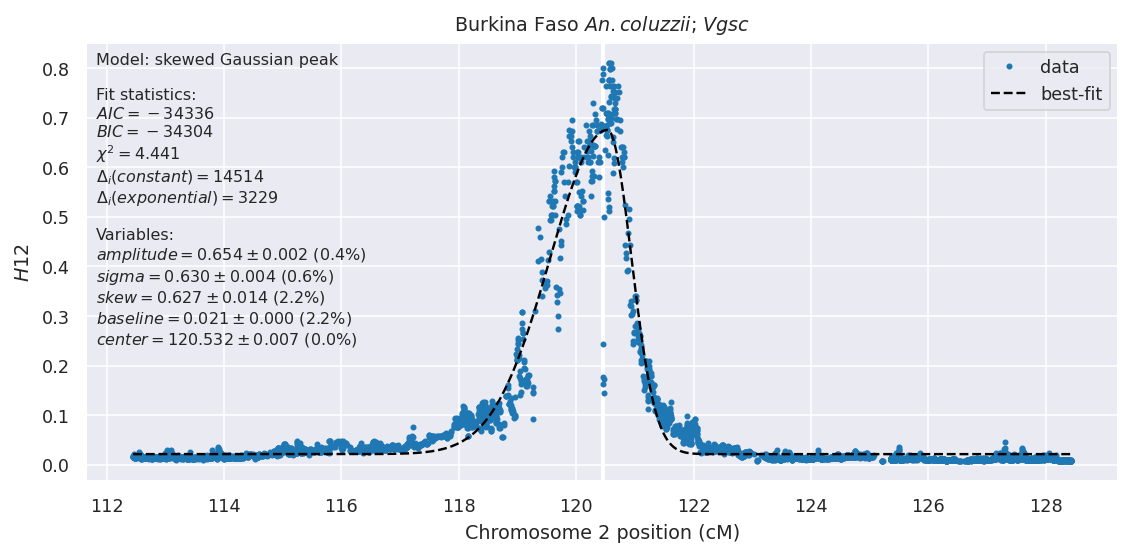

In [72]:
analyse_gaussian_peak_fit('bf_col', vgsc, 8)

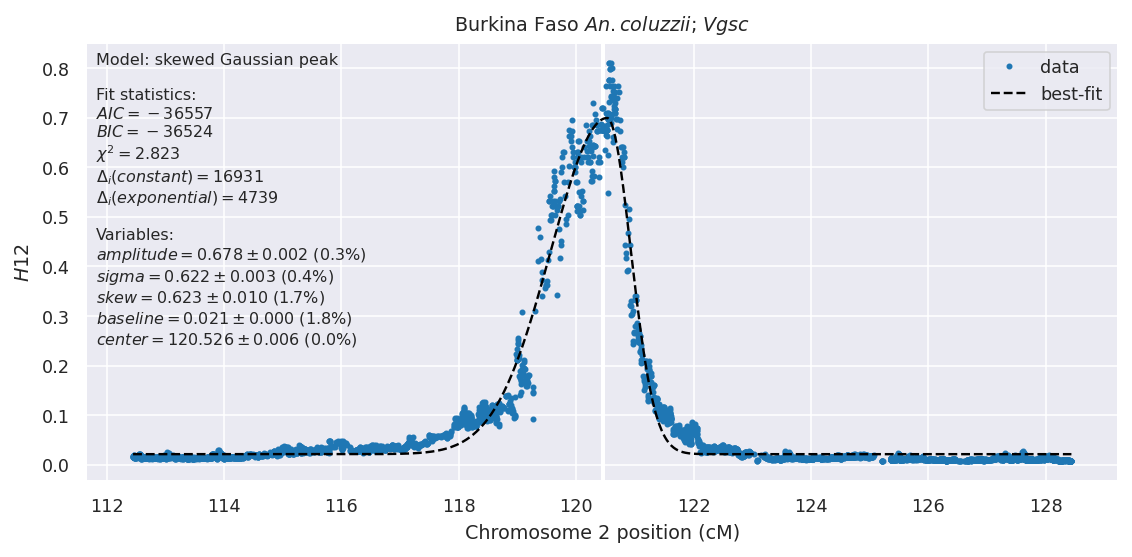

In [73]:
analyse_gaussian_peak_fit('bf_col', vgsc, 8, hampel_filter_kws=dict(size=20, t=2))

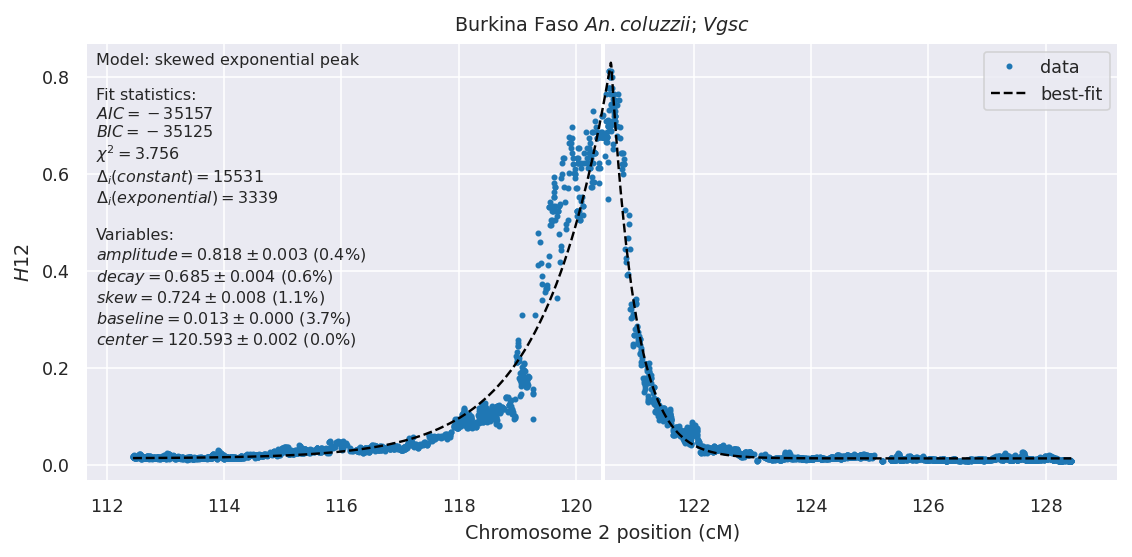

In [74]:
analyse_skewed_exponential_peak_fit('bf_col', vgsc, 8, hampel_filter_kws=dict(size=20, t=2))

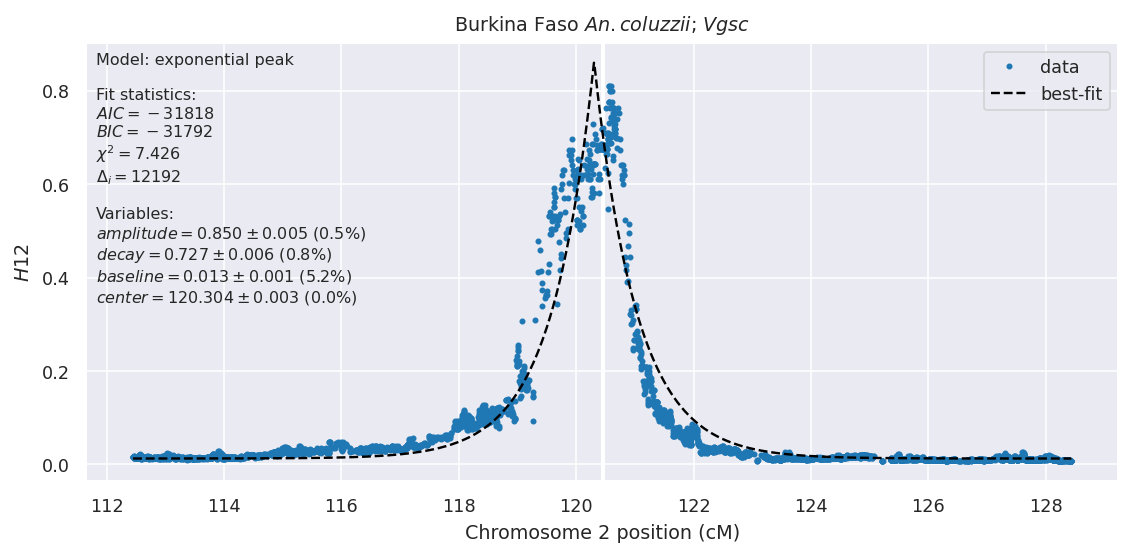

In [75]:
analyse_exponential_peak_fit('bf_col', vgsc, 8, hampel_filter_kws=dict(size=20, t=2))

## Analysis

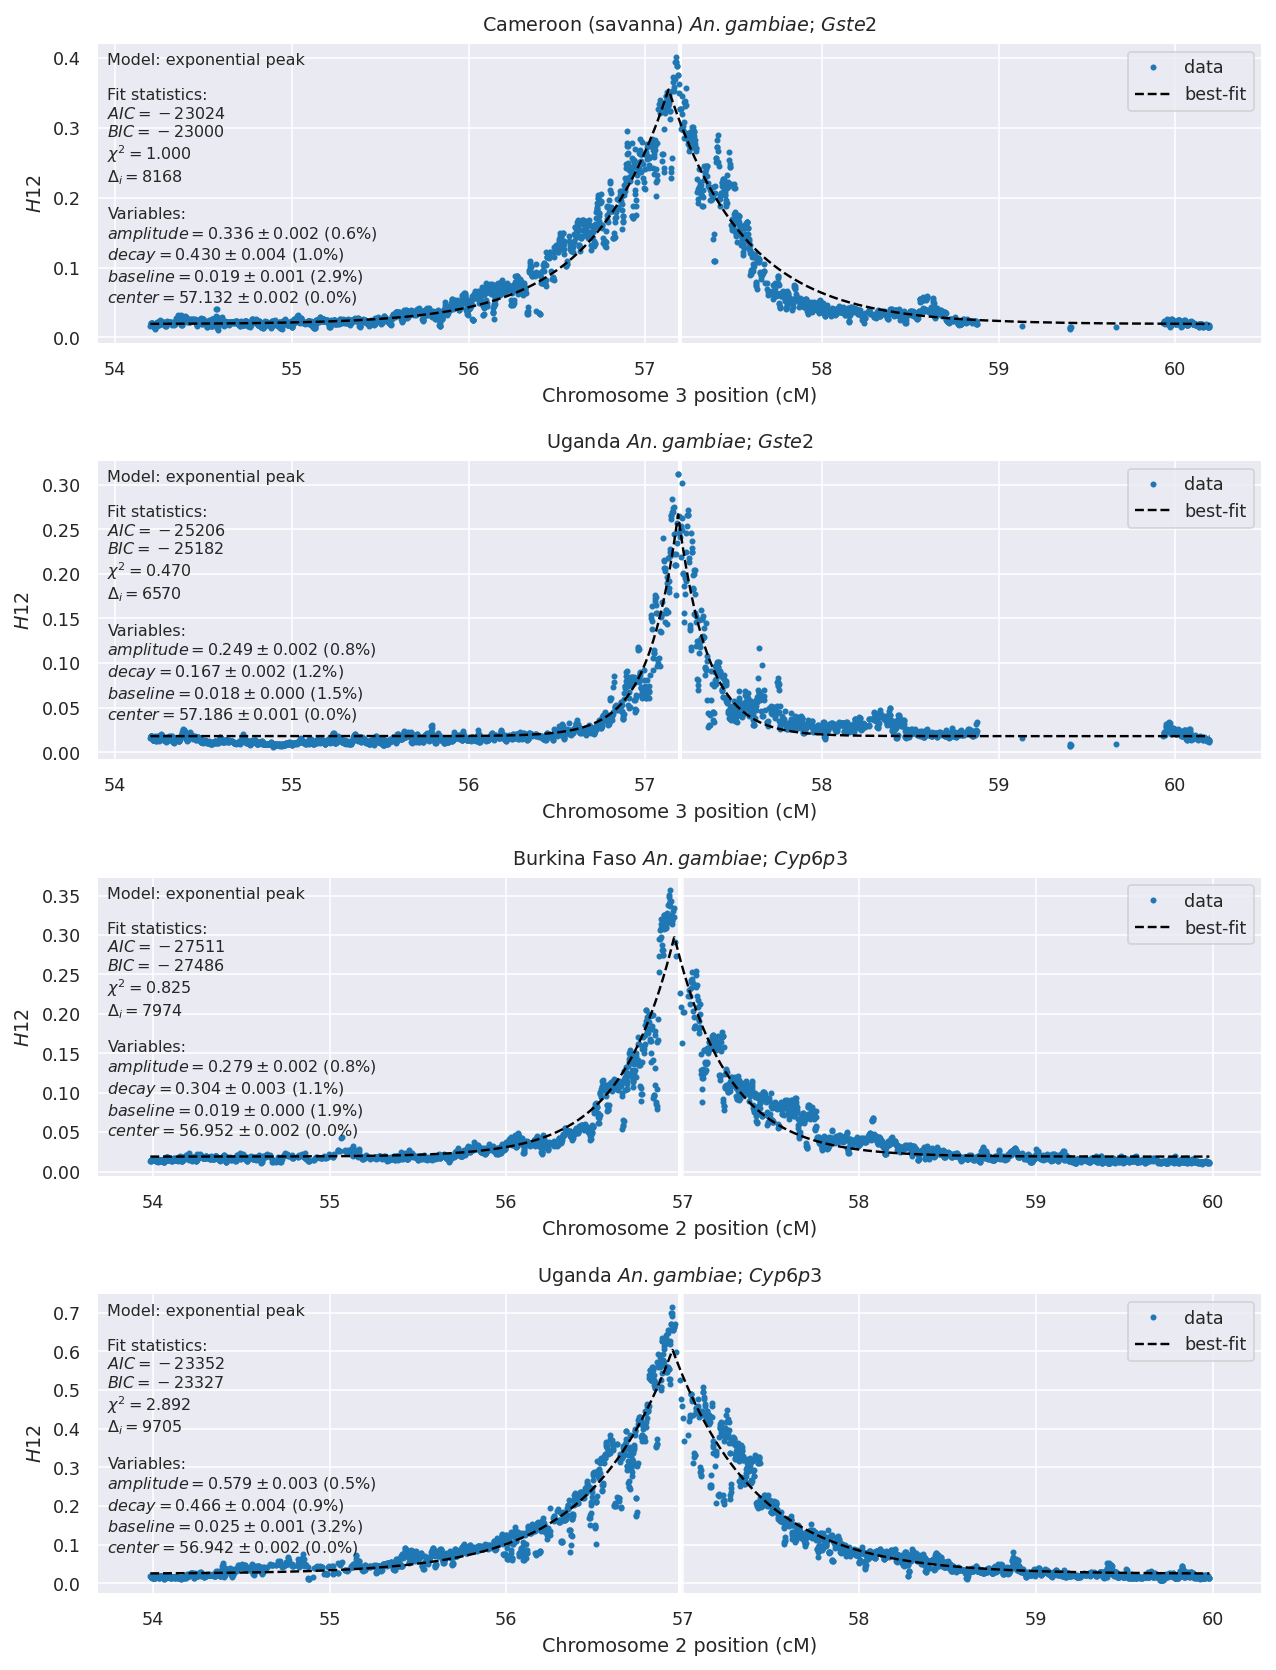

In [76]:
figw = 9
figh = (10.75/8.25) * figw

fig = plt.figure(facecolor='w', figsize=(figw, figh))

tracks = [
    ('cm_sav_gam', gste2, 3),
    ('ug_gam', gste2, 3),
    ('bf_gam', cyp6p3, 3),
    ('ug_gam', cyp6p3, 3),
]

nrows = len(tracks)

for i, (pop, gene, flank) in enumerate(tracks):

    ax = fig.add_subplot(nrows, 1, i+1)
    analyse_exponential_peak_fit(pop, gene, flank, ax=ax)

fig.tight_layout()
fig.savefig(here() / 'artwork/exponential_fit_examples.png', bbox_inches='tight',
            dpi=150)